In [1]:
# Imports
import os
import sys
import json
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import savemat,loadmat
from scipy.spatial.distance import cosine

### Define data wrangling functions
`load_data(fname):` Defines a function to return us:

1. `subjects`: A list of subject names
2. `list_order`: Order of lists by numbers (to track different orders of presentation to different subject groups)
3. `word_lists`: List of words in each list in order of presentation (name of list is **Critical Lure**)
4. `recall_data`: Recall data dictionary by subject name (within subject data)
5. `list_data`: Recall data dictionary by lists (within list data)

In [2]:
def safe_int(i):
    try:
        return int(i)
    except Exception as e:
        print(e,file=sys.stderr)
        return None

def load_data(fname):
    subjects = []
    list_order = []
    word_lists = dict()
    recall_data = dict()
    subject_matrix = None
    list_matrix = None
    # Read data by subjects
    with open(fname,'r') as fin:
        subjects = fin.readline().strip().split(',')[2:]
        recall_data = {s: dict() for s in subjects}
        # Read 17 lines per word list
        for critical_lure in fin:
            crit_li = critical_lure.strip().split(',')
            crit_word = crit_li[1].strip()
            list_order.append(crit_word)
            word_lists[crit_word] = []
            for i, s in enumerate(subjects):
                recall_data[s][crit_word] = [safe_int(crit_li[i+2].strip())]
            for k in range(15):
                word_li = fin.readline().strip().split(',')
                word = word_li[1].strip()
                word_lists[crit_word].append(word)
                for i, s in enumerate(subjects):
                    recall_data[s][crit_word].append(safe_int(word_li[i+2].strip()))
            distractors_li = fin.readline().strip().split(',')
            for i, s in enumerate(subjects):
                recall_data[s][crit_word].append(safe_int(distractors_li[i+2].strip()))
    # Format data by wordlist
    list_data = {w: dict() for w in list_order}
    for wlist in word_lists.keys():
        list_data[wlist] = {s: recall_data[s][wlist] for s in subjects}
    # Format data into matrices for fast computation with numpy
    subject_matrix = {s: np.zeros((17,len(list_order))) for s in subjects}
    for s in subjects:
        for i, w in enumerate(list_order):
            subject_matrix[s][:,i] = recall_data[s][w]
    list_matrix = {w: np.zeros((17,len(subjects))) for w in list_order}
    for w in list_order:
        for i, s in enumerate(subjects):
            list_matrix[w][:,i] = list_data[w][s]
    # Return read data
    return subjects, list_order, word_lists, recall_data, list_data, subject_matrix, list_matrix

`get_recall_rate(wlist, li_data):` Defines a function to compute serial position recall rates given numpy matrix of recall columns

In [3]:
# Takes in dictionary of matrix of recall events and a key specifying which entry to look into
# Returns recall rate per row (item) and overall distractor recall rate (non-presented items)
def get_recall_rate(mat, key, verbose=False):
    if (key not in mat):
        print(f"Error, cannot find {key}")
        return None, None
    has_recall_event = np.sum(mat[key]>0, axis=1)
    serial_recall = has_recall_event/mat[key].shape[1]
    raw_recall = sum(has_recall_event[:-1])
    raw_distractions = 0
    raw_critical = 0
    num_distraction_events = 0
    for i in range(mat[key].shape[1]):
        if (mat[key][0,i] or mat[key][-1,i]):
            num_distraction_events += 1
        has_crit = 1 if mat[key][0,i] else 0
        raw_critical += has_crit
        raw_distractions += mat[key][-1,i] + has_crit
        raw_recall += mat[key][-1,i]
    distraction_rate = num_distraction_events/mat[key].shape[1]
    if (verbose):
        print(f"Entry: {key}")
        print("Number of distractors recalled/total recalls: " +
            f"{safe_int(raw_distractions)}/{safe_int(raw_recall)} | {raw_distractions/raw_recall*100:.3f}%")
        if (safe_int(raw_distractions) > 0):
            print("Number of critial lure recalls/total distractor recalls: " +
                f"{safe_int(raw_critical)}/{safe_int(raw_distractions)} | {raw_critical/raw_distractions*100:.3f}%")
        else:
            print("Number of critial lure recalls/total distractor recalls: NONE")
    return serial_recall,distraction_rate

### Read data from formated .csv file

csv file sample:
```
Ss/list order:	words	1a	2a	3a	4a	5a
CL	rubber	7	0	0	0	0
1	elastic	2	2	9	9	4
2	bounce	0	5	7	5	5
3	gloves	9	0	11	10	0
4	tire	0	7	5	11	7
5	ball	1	4	8	6	0
```
Where each column is the recall position by subject and every 17 rows forms a presented word list

In [4]:
# Global Recall Data
subjects, list_order, word_lists, recall_data, list_data, subject_matrix, list_matrix = load_data("raw_recall_data_nanfilled.csv")

### Test our data structures
- Print list of word lists
- Plot serial position curve for selected lists

In [5]:
# Word Lists
print("Word Lists (labeled by critical lure):")
print(list_order)
# List recall
print("Within List level aggregate recall rates (across subjects):")
print(get_recall_rate(list_matrix,list_order[0]))
# Subject recall
print("Within Subject level aggregate recall rates (across lists):")
print(get_recall_rate(subject_matrix,"1a"))

Word Lists (labeled by critical lure):
['rubber', 'command', 'king', 'city', 'whistle', 'trash', 'cabbage', 'health', 'mutton', 'rough', 'carpet', 'justice', 'bitter', 'long', 'citizen', 'butterfly', 'pen', 'lamp', 'foot', 'wish', 'smoke', 'needle', 'beautiful', 'cottage', 'whiskey', 'swift', 'trouble', 'stove']
Within List level aggregate recall rates (across subjects):
(array([0.2125, 0.8   , 0.675 , 0.425 , 0.4125, 0.6   , 0.325 , 0.3875,
       0.225 , 0.5125, 0.425 , 0.65  , 0.5   , 0.5375, 0.7625, 0.95  ,
       0.225 ]), 0.375)
Within Subject level aggregate recall rates (across lists):
(array([0.25      , 0.67857143, 0.71428571, 0.39285714, 0.42857143,
       0.46428571, 0.39285714, 0.35714286, 0.42857143, 0.32142857,
       0.57142857, 0.53571429, 0.75      , 0.64285714, 0.96428571,
       0.92857143, 0.35714286]), 0.5357142857142857)


Notice that in our output vector of % recall, at the 0-index is rate of **critical lure** recall and -1(last)-index is the rate of **distractors** recall (non-presented items which are also not the lure)

In [6]:
# Uncomment the following cell to run diagnostics on data structure

# # Individual wordlist matrix
# print(f"List: {list_order[0]}")
# print(list_matrix[list_order[0]])

# # Individual subject matrix
# print("Subject: 1a")
# print(subject_matrix["1a"])

# # Aggregate list serial recalls
# for w in list_order:
#     print(f"List {w} recall rates:")
#     print(get_recall_rate(list_matrix,w))

## Data visualizations

### Plotting function for serial position

The following defines helper plotting utilities for Serial Position as well as a bar chart for distraction recalls

In [7]:
# Takes in a column vector of recall % in order of presentation
def plot_serial_position(serial_pos):
    plt.plot(range(len(serial_pos)),serial_pos,'bo-')
    plt.show()
    
# Digests recall rate together with rates of False Recall
def plot_list_recall(args):
    list_recall = args[0]
    distraction_rate = None
    if (len(args) > 1):
        distraction_rate = args[1]
    critical_lure = list_recall[0]
    distractors = list_recall[-1]
    serial_pos = list_recall[1:-1]
    f,(p1,p2) = plt.subplots(1,2,figsize=(10,3),gridspec_kw={'width_ratios':[4,1.5]})
    p1.set_ylim([0,1])
    p2.set_ylim([0,1])
    p1.plot(range(len(serial_pos)),serial_pos,'bo-')
    if (distraction_rate is not None):
        p2.bar(["Critical","Others","Total"],[critical_lure,distractors,distraction_rate])
    else:
        p2.bar(["Critical","Others"],[critical_lure,distractors])
    plt.show()

### Plotting function for heatmap (visualize multiple lists/subjects in one figure)

The following defines a helper function to visualize multiple lists/subjects as a heatmap (darker -> higher %)
Last 3 cells are: %critical recall, %non-critical distraction recalls, %total non-presented recalls

In [8]:
# Helps us format data returned from previous get_recall_rate
def format_recall_matrix(mat, keylist):
    # Grab all matrices in dictionary and format:
    # first 15 rows serial recall
    # last 3 rows critical recall, others recall, total non-presented recall
    out_mat = np.zeros((18,len(keylist)))
    for i, key in enumerate(keylist):
        list_recall,non_presented_distraction_rate = get_recall_rate(mat,key)
        if (list_recall is not None):
            critical_lure = list_recall[0]
            distraction_rate = list_recall[-1]
            serial_pos = list_recall[1:-1]
            out_mat[:,i] = np.append(serial_pos, [critical_lure,distraction_rate,non_presented_distraction_rate])
    return out_mat

# Takes in formatted matrix of [serial recalls ; distractors]
def plot_matrix_heatmap(mat,keylist=None,size=(10,3)):
    plt.figure(figsize=size)
    plt.imshow(mat,cmap='cool',interpolation='nearest')
    if (keylist is not None): # Set axis labels if given
        plt.xticks(ticks=range(len(keylist)),labels=keylist,rotation=90)
    plt.show()

### Examples
Below are some example plots using the above defined utilities.

1. Serial position curve and bar chart showing %distraction recalls
2. Matrix heatmap of all lists side by side, we see that in particular, the 'rough' and 'needle' lists have high probability of false recall
3. Matrix heatmap of all subjects side by side, we observe that some subjects behave anomalously (58a, 53b, 72c - perhaps they just have bad memory)

Entry: rough
Number of distractors recalled/total recalls: 77/733 | 10.505%
Number of critial lure recalls/total distractor recalls: 43/77 | 55.844%


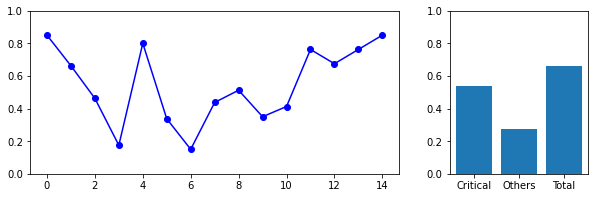

Serial position data for all lists (aggregated across subjects)


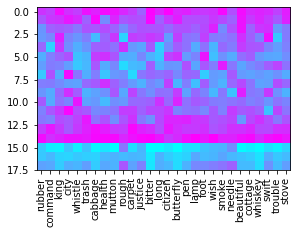

Serial position data for all subjects (aggregated across lists)


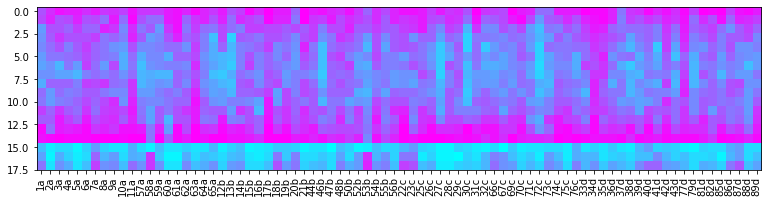

In [9]:
# Serial position curve for the 'rough' list
plot_list_recall(get_recall_rate(list_matrix,"rough",verbose=True))
# Matrix heatmap for all lists
print("Serial position data for all lists (aggregated across subjects)")
plot_matrix_heatmap(format_recall_matrix(list_matrix,list_order),list_order)
# Matrix heatmap for all subjects
print("Serial position data for all subjects (aggregated across lists)")
plot_matrix_heatmap(format_recall_matrix(subject_matrix,subjects),keylist=subjects,size=(20,3))

### Serial Position plots for all lists
Run the following cell to plot serial position curves for each list aggregated across all subjects

Plotting Serial position graph for list: rubber
Entry: rubber
Number of distractors recalled/total recalls: 43/698 | 6.160%
Number of critial lure recalls/total distractor recalls: 17/43 | 39.535%


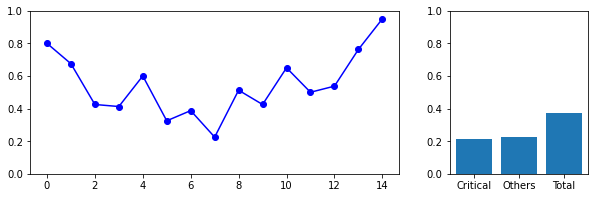

Plotting Serial position graph for list: command
Entry: command
Number of distractors recalled/total recalls: 39/729 | 5.350%
Number of critial lure recalls/total distractor recalls: 6/39 | 15.385%


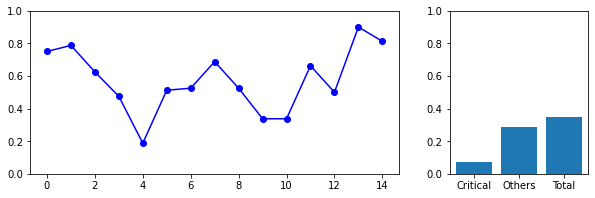

Plotting Serial position graph for list: king
Entry: king
Number of distractors recalled/total recalls: 27/845 | 3.195%
Number of critial lure recalls/total distractor recalls: 5/27 | 18.519%


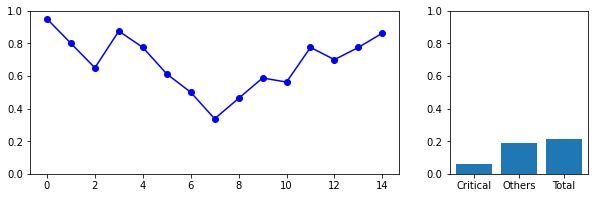

Plotting Serial position graph for list: city
Entry: city
Number of distractors recalled/total recalls: 37/853 | 4.338%
Number of critial lure recalls/total distractor recalls: 19/37 | 51.351%


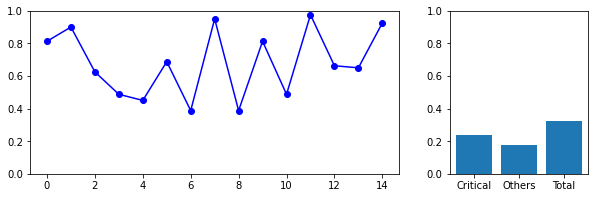

Plotting Serial position graph for list: whistle
Entry: whistle
Number of distractors recalled/total recalls: 32/750 | 4.267%
Number of critial lure recalls/total distractor recalls: 7/32 | 21.875%


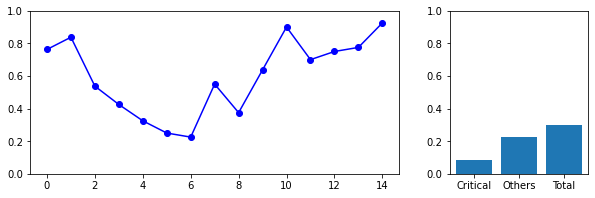

Plotting Serial position graph for list: trash
Entry: trash
Number of distractors recalled/total recalls: 38/732 | 5.191%
Number of critial lure recalls/total distractor recalls: 20/38 | 52.632%


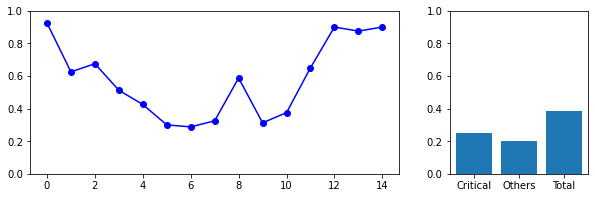

Plotting Serial position graph for list: cabbage
Entry: cabbage
Number of distractors recalled/total recalls: 21/799 | 2.628%
Number of critial lure recalls/total distractor recalls: 4/21 | 19.048%


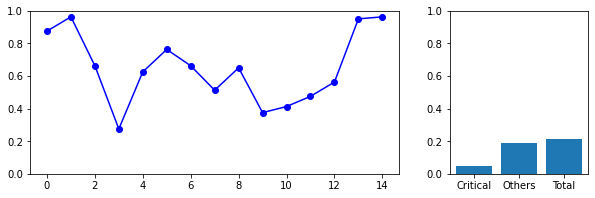

Plotting Serial position graph for list: health
Entry: health
Number of distractors recalled/total recalls: 35/779 | 4.493%
Number of critial lure recalls/total distractor recalls: 9/35 | 25.714%


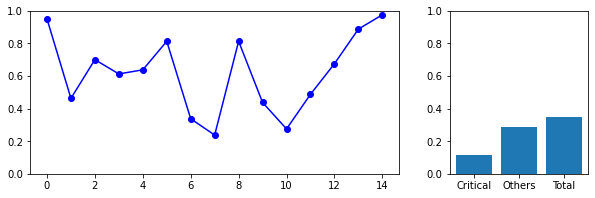

Plotting Serial position graph for list: mutton
Entry: mutton
Number of distractors recalled/total recalls: 48/832 | 5.769%
Number of critial lure recalls/total distractor recalls: 1/48 | 2.083%


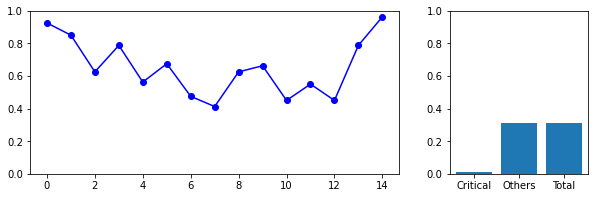

Plotting Serial position graph for list: rough
Entry: rough
Number of distractors recalled/total recalls: 77/733 | 10.505%
Number of critial lure recalls/total distractor recalls: 43/77 | 55.844%


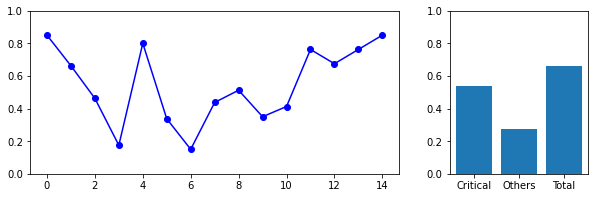

Plotting Serial position graph for list: carpet
Entry: carpet
Number of distractors recalled/total recalls: 48/784 | 6.122%
Number of critial lure recalls/total distractor recalls: 12/48 | 25.000%


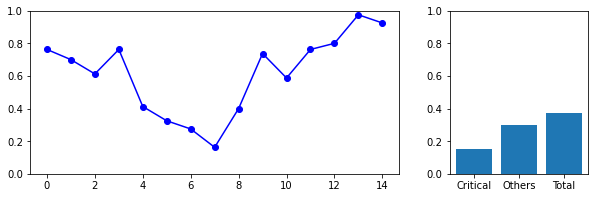

Plotting Serial position graph for list: justice
Entry: justice
Number of distractors recalled/total recalls: 51/759 | 6.719%
Number of critial lure recalls/total distractor recalls: 24/51 | 47.059%


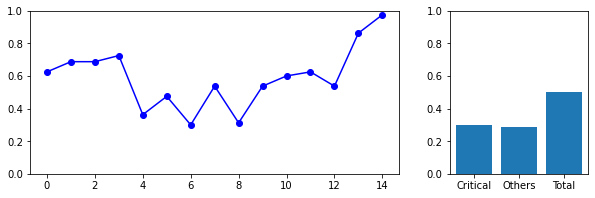

Plotting Serial position graph for list: bitter
Entry: bitter
Number of distractors recalled/total recalls: 12/822 | 1.460%
Number of critial lure recalls/total distractor recalls: 1/12 | 8.333%


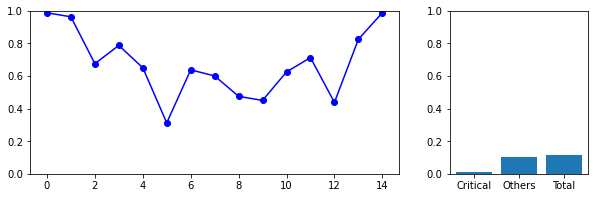

Plotting Serial position graph for list: long
Entry: long
Number of distractors recalled/total recalls: 30/753 | 3.984%
Number of critial lure recalls/total distractor recalls: 2/30 | 6.667%


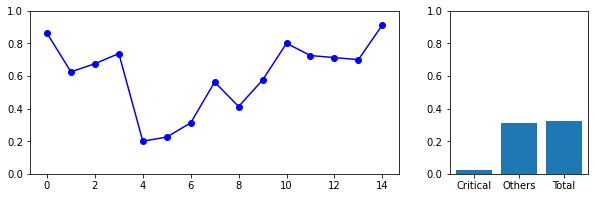

Plotting Serial position graph for list: citizen
Entry: citizen
Number of distractors recalled/total recalls: 28/844 | 3.318%
Number of critial lure recalls/total distractor recalls: 8/28 | 28.571%


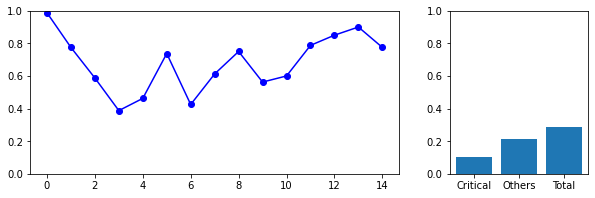

Plotting Serial position graph for list: butterfly
Entry: butterfly
Number of distractors recalled/total recalls: 13/846 | 1.537%
Number of critial lure recalls/total distractor recalls: 1/13 | 7.692%


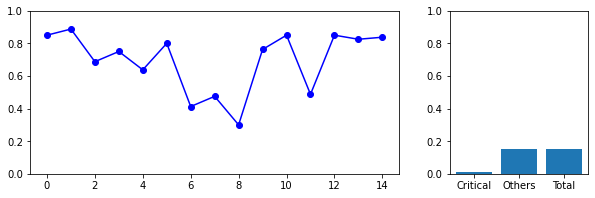

Plotting Serial position graph for list: pen
Entry: pen
Number of distractors recalled/total recalls: 30/803 | 3.736%
Number of critial lure recalls/total distractor recalls: 11/30 | 36.667%


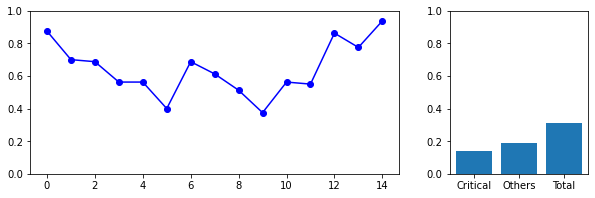

Plotting Serial position graph for list: lamp
Entry: lamp
Number of distractors recalled/total recalls: 57/783 | 7.280%
Number of critial lure recalls/total distractor recalls: 11/57 | 19.298%


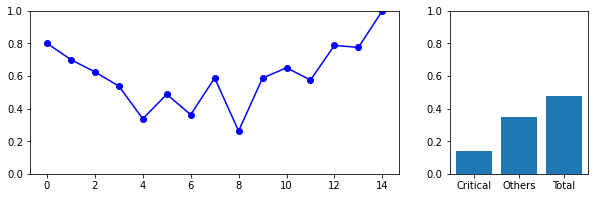

Plotting Serial position graph for list: foot
Entry: foot
Number of distractors recalled/total recalls: 49/849 | 5.771%
Number of critial lure recalls/total distractor recalls: 20/49 | 40.816%


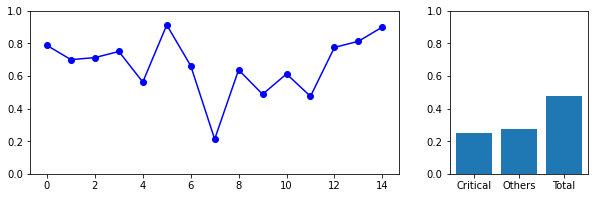

Plotting Serial position graph for list: wish
Entry: wish
Number of distractors recalled/total recalls: 52/744 | 6.989%
Number of critial lure recalls/total distractor recalls: 23/52 | 44.231%


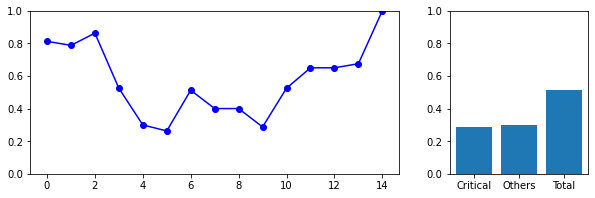

Plotting Serial position graph for list: smoke
Entry: smoke
Number of distractors recalled/total recalls: 61/787 | 7.751%
Number of critial lure recalls/total distractor recalls: 25/61 | 40.984%


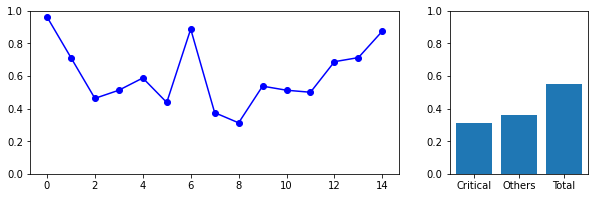

Plotting Serial position graph for list: needle
Entry: needle
Number of distractors recalled/total recalls: 67/803 | 8.344%
Number of critial lure recalls/total distractor recalls: 36/67 | 53.731%


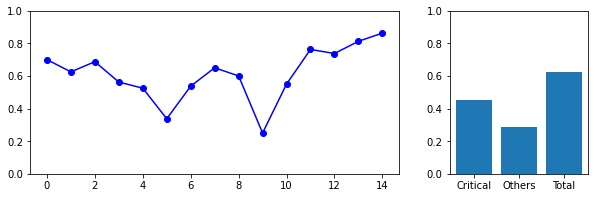

Plotting Serial position graph for list: beautiful
Entry: beautiful
Number of distractors recalled/total recalls: 25/880 | 2.841%
Number of critial lure recalls/total distractor recalls: 2/25 | 8.000%


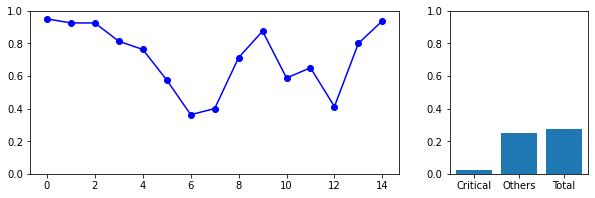

Plotting Serial position graph for list: cottage
Entry: cottage
Number of distractors recalled/total recalls: 27/813 | 3.321%
Number of critial lure recalls/total distractor recalls: 6/27 | 22.222%


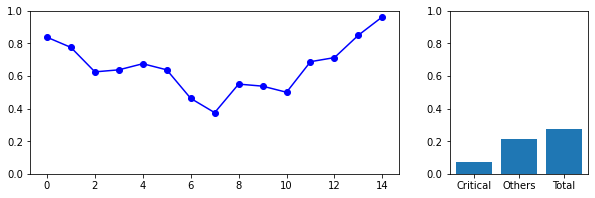

Plotting Serial position graph for list: whiskey
Entry: whiskey
Number of distractors recalled/total recalls: 18/771 | 2.335%
Number of critial lure recalls/total distractor recalls: 2/18 | 11.111%


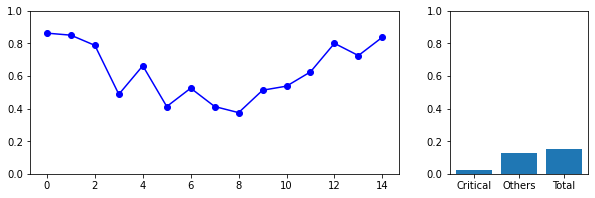

Plotting Serial position graph for list: swift
Entry: swift
Number of distractors recalled/total recalls: 48/801 | 5.993%
Number of critial lure recalls/total distractor recalls: 11/48 | 22.917%


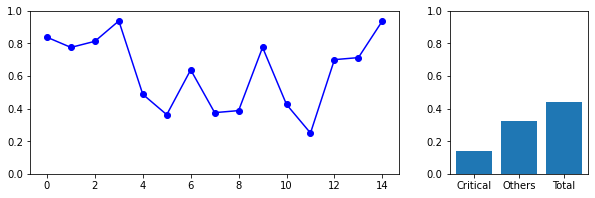

Plotting Serial position graph for list: trouble
Entry: trouble
Number of distractors recalled/total recalls: 27/722 | 3.740%
Number of critial lure recalls/total distractor recalls: 6/27 | 22.222%


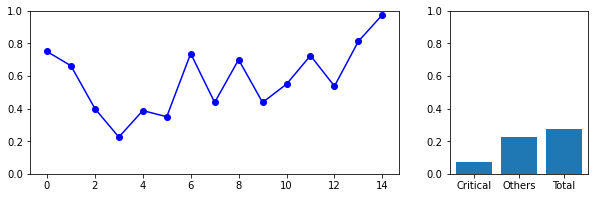

Plotting Serial position graph for list: stove
Entry: stove
Number of distractors recalled/total recalls: 43/764 | 5.628%
Number of critial lure recalls/total distractor recalls: 14/43 | 32.558%


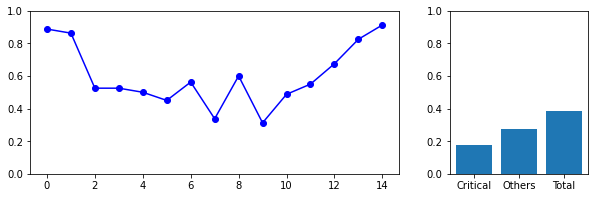

In [10]:
for w in list_order:
    print(f"Plotting Serial position graph for list: {w}")
    plot_list_recall(get_recall_rate(list_matrix,w,verbose=True))

### Serial Position plots for each subject
Run the following cell to plot within subject performance across all lists they were tasked to recall on

Plotting Serial position graph for subject: 1a
Entry: 1a
Number of distractors recalled/total recalls: 21/261 | 8.046%
Number of critial lure recalls/total distractor recalls: 7/21 | 33.333%


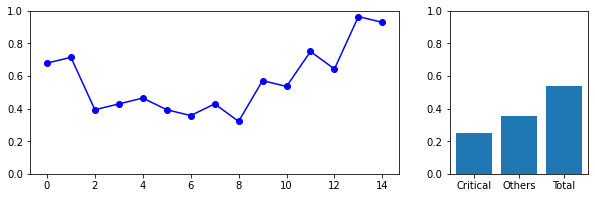

Plotting Serial position graph for subject: 2a
Entry: 2a
Number of distractors recalled/total recalls: 3/259 | 1.158%
Number of critial lure recalls/total distractor recalls: 2/3 | 66.667%


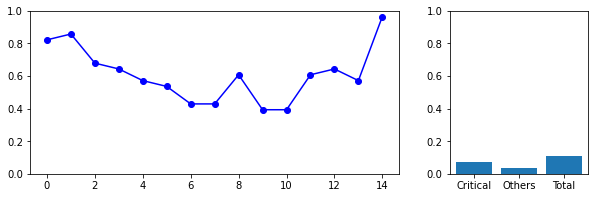

Plotting Serial position graph for subject: 3a
Entry: 3a
Number of distractors recalled/total recalls: 15/300 | 5.000%
Number of critial lure recalls/total distractor recalls: 4/15 | 26.667%


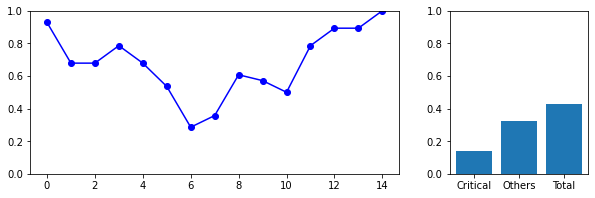

Plotting Serial position graph for subject: 4a
Entry: 4a
Number of distractors recalled/total recalls: 9/281 | 3.203%
Number of critial lure recalls/total distractor recalls: 4/9 | 44.444%


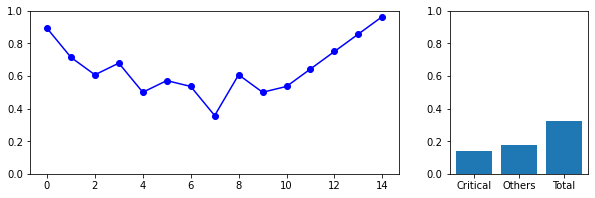

Plotting Serial position graph for subject: 5a
Entry: 5a
Number of distractors recalled/total recalls: 3/278 | 1.079%
Number of critial lure recalls/total distractor recalls: 1/3 | 33.333%


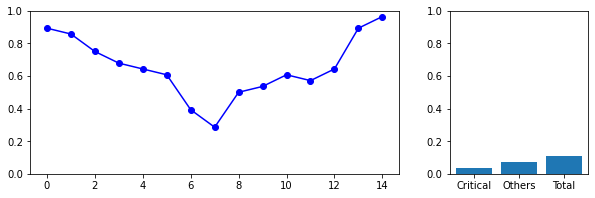

Plotting Serial position graph for subject: 6a
Entry: 6a
Number of distractors recalled/total recalls: 9/323 | 2.786%
Number of critial lure recalls/total distractor recalls: 5/9 | 55.556%


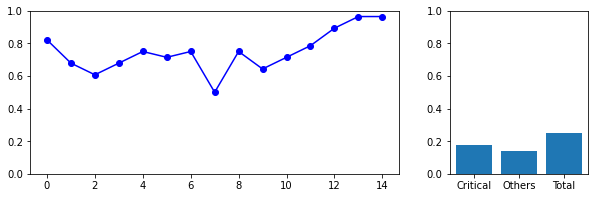

Plotting Serial position graph for subject: 7a
Entry: 7a
Number of distractors recalled/total recalls: 38/327 | 11.621%
Number of critial lure recalls/total distractor recalls: 11/38 | 28.947%


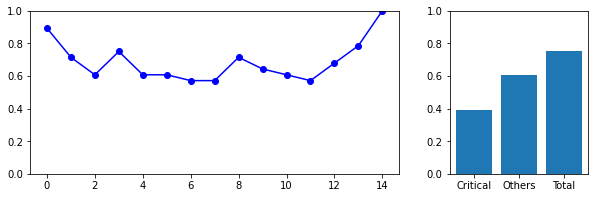

Plotting Serial position graph for subject: 8a
Entry: 8a
Number of distractors recalled/total recalls: 16/300 | 5.333%
Number of critial lure recalls/total distractor recalls: 5/16 | 31.250%


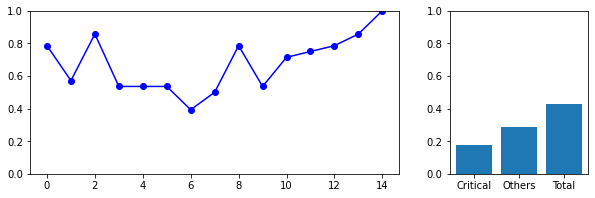

Plotting Serial position graph for subject: 9a
Entry: 9a
Number of distractors recalled/total recalls: 15/311 | 4.823%
Number of critial lure recalls/total distractor recalls: 3/15 | 20.000%


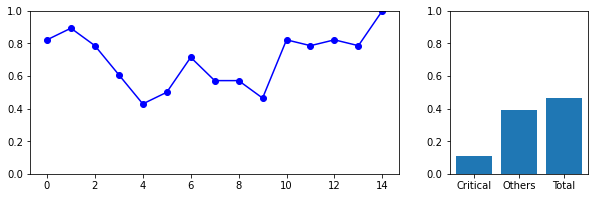

Plotting Serial position graph for subject: 10a
Entry: 10a
Number of distractors recalled/total recalls: 7/243 | 2.881%
Number of critial lure recalls/total distractor recalls: 3/7 | 42.857%


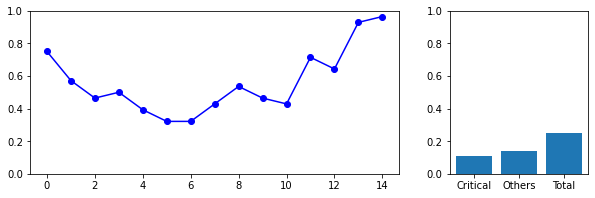

Plotting Serial position graph for subject: 11a
Entry: 11a
Number of distractors recalled/total recalls: 18/355 | 5.070%
Number of critial lure recalls/total distractor recalls: 9/18 | 50.000%


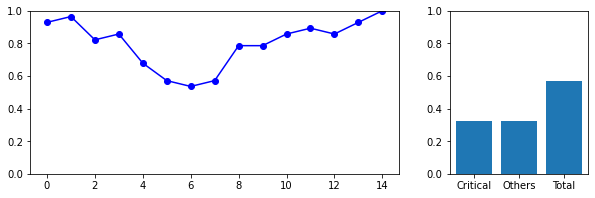

Plotting Serial position graph for subject: 57a
Entry: 57a
Number of distractors recalled/total recalls: 12/240 | 5.000%
Number of critial lure recalls/total distractor recalls: 4/12 | 33.333%


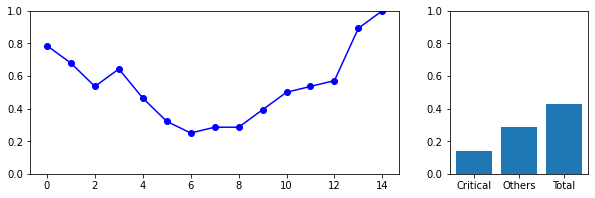

Plotting Serial position graph for subject: 58a
Entry: 58a
Number of distractors recalled/total recalls: 47/245 | 19.184%
Number of critial lure recalls/total distractor recalls: 1/47 | 2.128%


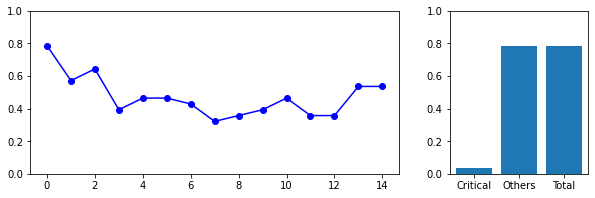

Plotting Serial position graph for subject: 59a
Entry: 59a
Number of distractors recalled/total recalls: 15/252 | 5.952%
Number of critial lure recalls/total distractor recalls: 7/15 | 46.667%


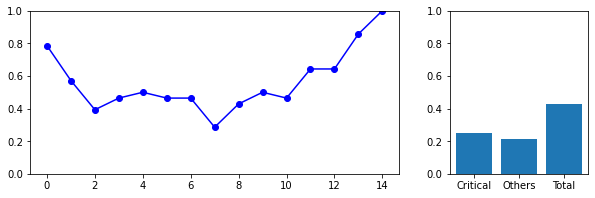

Plotting Serial position graph for subject: 60a
Entry: 60a
Number of distractors recalled/total recalls: 4/236 | 1.695%
Number of critial lure recalls/total distractor recalls: 3/4 | 75.000%


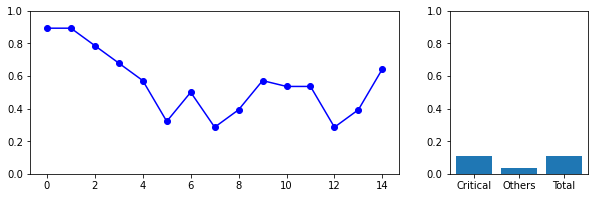

Plotting Serial position graph for subject: 61a
Entry: 61a
Number of distractors recalled/total recalls: 4/310 | 1.290%
Number of critial lure recalls/total distractor recalls: 3/4 | 75.000%


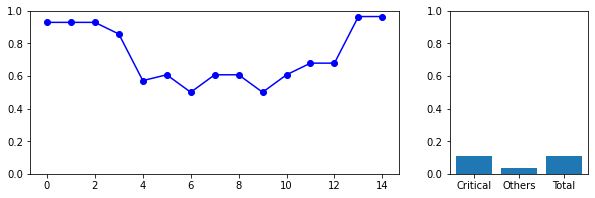

Plotting Serial position graph for subject: 62a
Entry: 62a
Number of distractors recalled/total recalls: 16/280 | 5.714%
Number of critial lure recalls/total distractor recalls: 5/16 | 31.250%


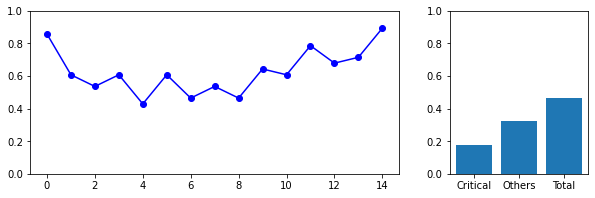

Plotting Serial position graph for subject: 63a
Entry: 63a
Number of distractors recalled/total recalls: 7/356 | 1.966%
Number of critial lure recalls/total distractor recalls: 3/7 | 42.857%


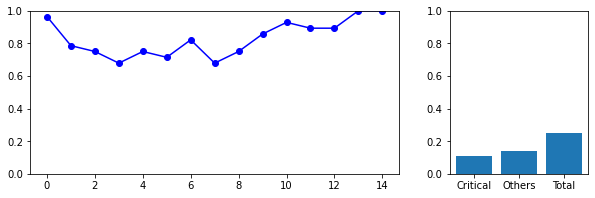

Plotting Serial position graph for subject: 64a
Entry: 64a
Number of distractors recalled/total recalls: 10/266 | 3.759%
Number of critial lure recalls/total distractor recalls: 3/10 | 30.000%


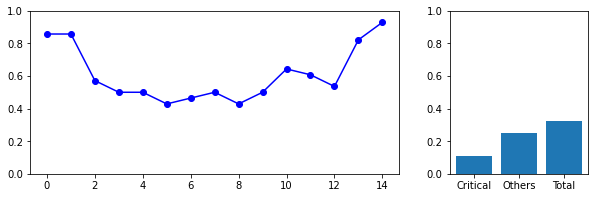

Plotting Serial position graph for subject: 65a
Entry: 65a
Number of distractors recalled/total recalls: 16/230 | 6.957%
Number of critial lure recalls/total distractor recalls: 8/16 | 50.000%


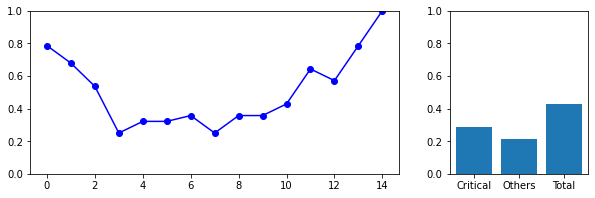

Plotting Serial position graph for subject: 12b
Entry: 12b
Number of distractors recalled/total recalls: 6/262 | 2.290%
Number of critial lure recalls/total distractor recalls: 2/6 | 33.333%


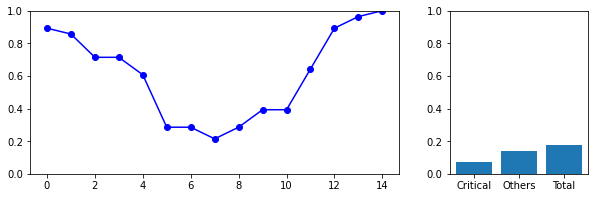

Plotting Serial position graph for subject: 13b
Entry: 13b
Number of distractors recalled/total recalls: 16/206 | 7.767%
Number of critial lure recalls/total distractor recalls: 5/16 | 31.250%


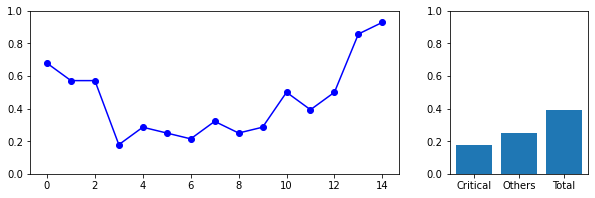

Plotting Serial position graph for subject: 14b
Entry: 14b
Number of distractors recalled/total recalls: 17/288 | 5.903%
Number of critial lure recalls/total distractor recalls: 7/17 | 41.176%


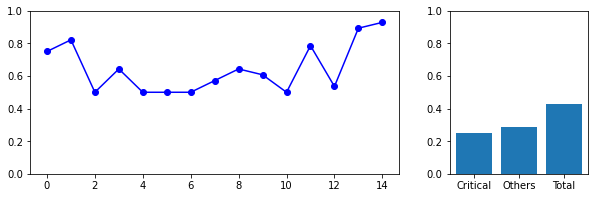

Plotting Serial position graph for subject: 15b
Entry: 15b
Number of distractors recalled/total recalls: 4/293 | 1.365%
Number of critial lure recalls/total distractor recalls: 1/4 | 25.000%


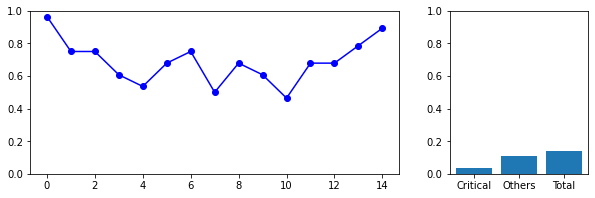

Plotting Serial position graph for subject: 16b
Entry: 16b
Number of distractors recalled/total recalls: 6/248 | 2.419%
Number of critial lure recalls/total distractor recalls: 2/6 | 33.333%


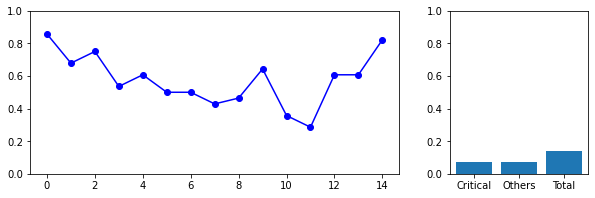

Plotting Serial position graph for subject: 17b
Entry: 17b
Number of distractors recalled/total recalls: 7/346 | 2.023%
Number of critial lure recalls/total distractor recalls: 3/7 | 42.857%


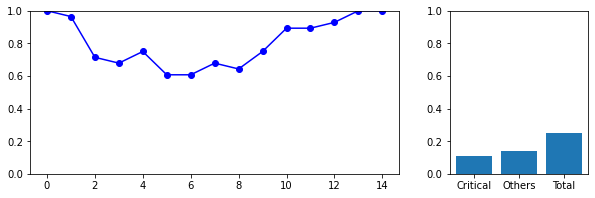

Plotting Serial position graph for subject: 18b
Entry: 18b
Number of distractors recalled/total recalls: 24/298 | 8.054%
Number of critial lure recalls/total distractor recalls: 6/24 | 25.000%


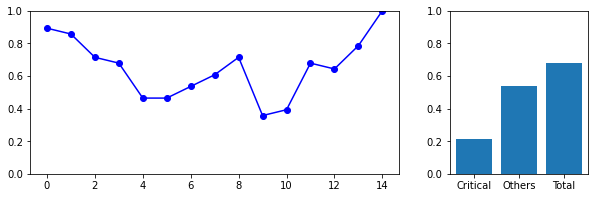

Plotting Serial position graph for subject: 19b
Entry: 19b
Number of distractors recalled/total recalls: 13/303 | 4.290%
Number of critial lure recalls/total distractor recalls: 6/13 | 46.154%


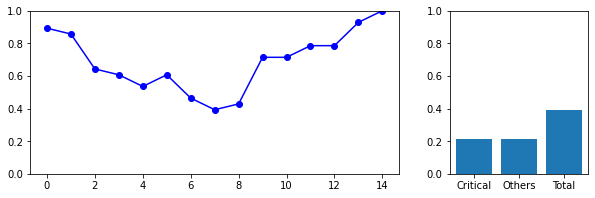

Plotting Serial position graph for subject: 20b
Entry: 20b
Number of distractors recalled/total recalls: 45/283 | 15.901%
Number of critial lure recalls/total distractor recalls: 5/45 | 11.111%


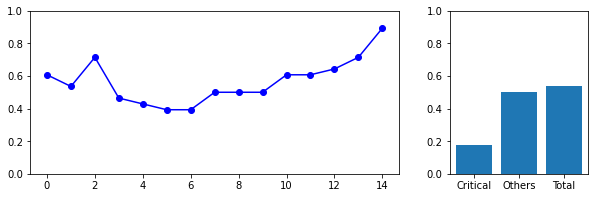

Plotting Serial position graph for subject: 21b
Entry: 21b
Number of distractors recalled/total recalls: 7/325 | 2.154%
Number of critial lure recalls/total distractor recalls: 1/7 | 14.286%


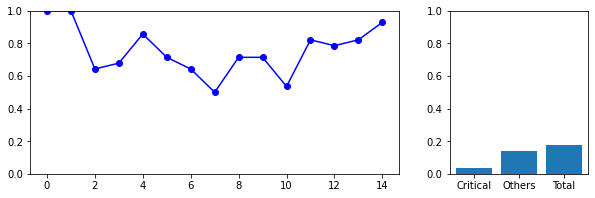

Plotting Serial position graph for subject: 44b
Entry: 44b
Number of distractors recalled/total recalls: 7/292 | 2.397%
Number of critial lure recalls/total distractor recalls: 3/7 | 42.857%


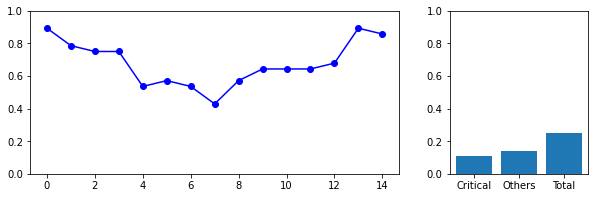

Plotting Serial position graph for subject: 46b
Entry: 46b
Number of distractors recalled/total recalls: 9/214 | 4.206%
Number of critial lure recalls/total distractor recalls: 3/9 | 33.333%


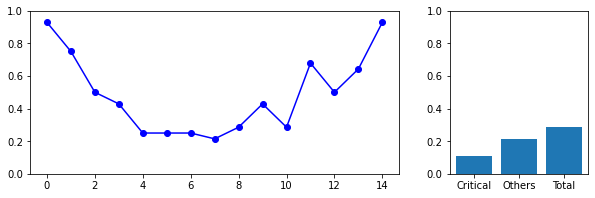

Plotting Serial position graph for subject: 47b
Entry: 47b
Number of distractors recalled/total recalls: 4/278 | 1.439%
Number of critial lure recalls/total distractor recalls: 0/4 | 0.000%


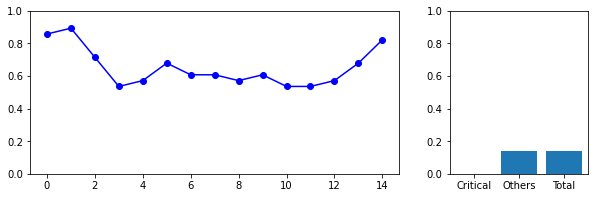

Plotting Serial position graph for subject: 48b
Entry: 48b
Number of distractors recalled/total recalls: 17/313 | 5.431%
Number of critial lure recalls/total distractor recalls: 7/17 | 41.176%


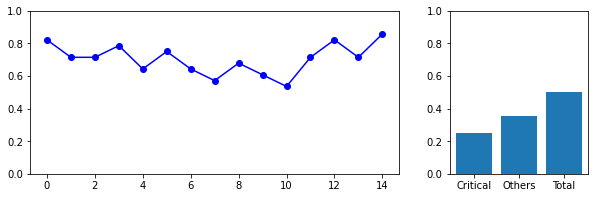

Plotting Serial position graph for subject: 50b
Entry: 50b
Number of distractors recalled/total recalls: 9/284 | 3.169%
Number of critial lure recalls/total distractor recalls: 5/9 | 55.556%


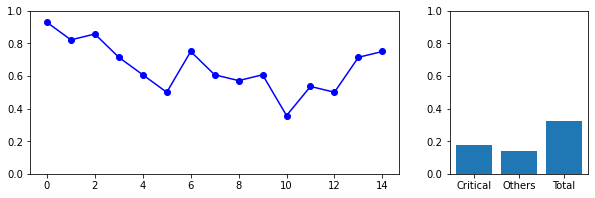

Plotting Serial position graph for subject: 52b
Entry: 52b
Number of distractors recalled/total recalls: 16/261 | 6.130%
Number of critial lure recalls/total distractor recalls: 1/16 | 6.250%


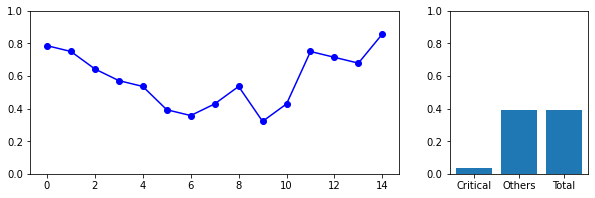

Plotting Serial position graph for subject: 53b
Entry: 53b
Number of distractors recalled/total recalls: 35/225 | 15.556%
Number of critial lure recalls/total distractor recalls: 2/35 | 5.714%


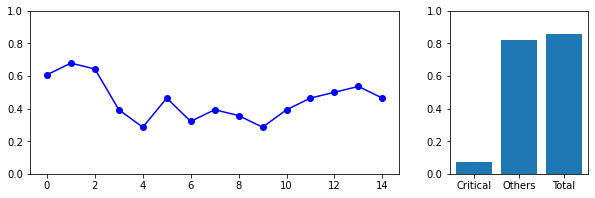

Plotting Serial position graph for subject: 54b
Entry: 54b
Number of distractors recalled/total recalls: 19/318 | 5.975%
Number of critial lure recalls/total distractor recalls: 7/19 | 36.842%


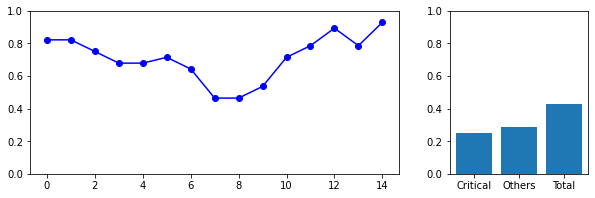

Plotting Serial position graph for subject: 55b
Entry: 55b
Number of distractors recalled/total recalls: 19/247 | 7.692%
Number of critial lure recalls/total distractor recalls: 4/19 | 21.053%


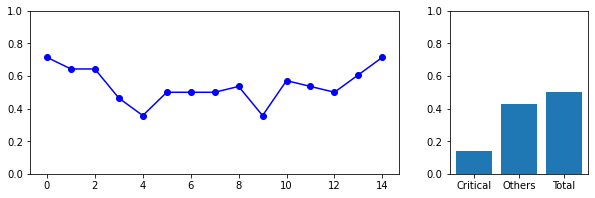

Plotting Serial position graph for subject: 56b
Entry: 56b
Number of distractors recalled/total recalls: 10/284 | 3.521%
Number of critial lure recalls/total distractor recalls: 5/10 | 50.000%


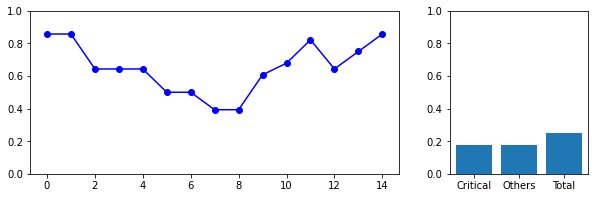

Plotting Serial position graph for subject: 22c
Entry: 22c
Number of distractors recalled/total recalls: 30/328 | 9.146%
Number of critial lure recalls/total distractor recalls: 8/30 | 26.667%


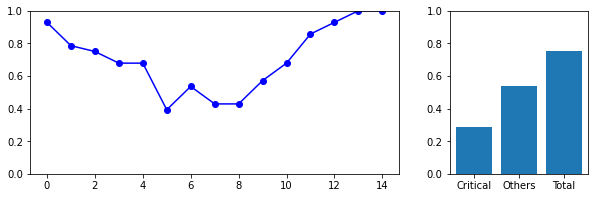

Plotting Serial position graph for subject: 23c
Entry: 23c
Number of distractors recalled/total recalls: 42/301 | 13.953%
Number of critial lure recalls/total distractor recalls: 11/42 | 26.190%


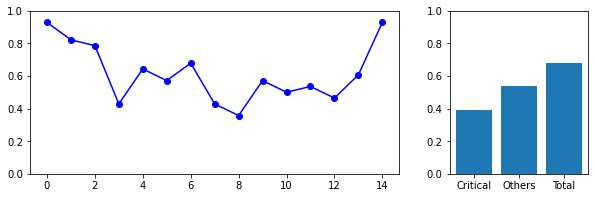

Plotting Serial position graph for subject: 25c
Entry: 25c
Number of distractors recalled/total recalls: 7/304 | 2.303%
Number of critial lure recalls/total distractor recalls: 5/7 | 71.429%


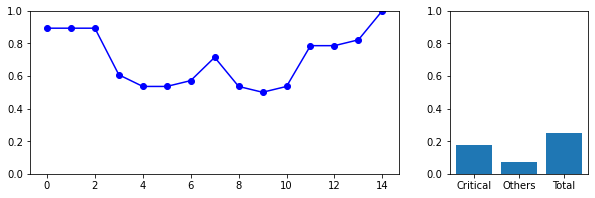

Plotting Serial position graph for subject: 26c
Entry: 26c
Number of distractors recalled/total recalls: 9/274 | 3.285%
Number of critial lure recalls/total distractor recalls: 4/9 | 44.444%


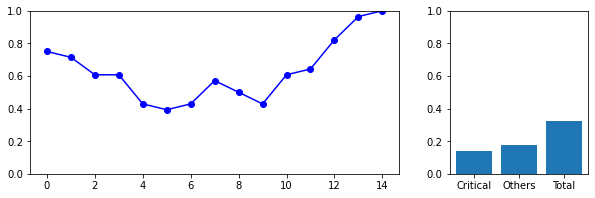

Plotting Serial position graph for subject: 27c
Entry: 27c
Number of distractors recalled/total recalls: 2/192 | 1.042%
Number of critial lure recalls/total distractor recalls: 1/2 | 50.000%


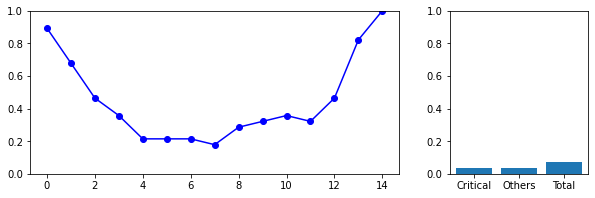

Plotting Serial position graph for subject: 28c
Entry: 28c
Number of distractors recalled/total recalls: 2/278 | 0.719%
Number of critial lure recalls/total distractor recalls: 1/2 | 50.000%


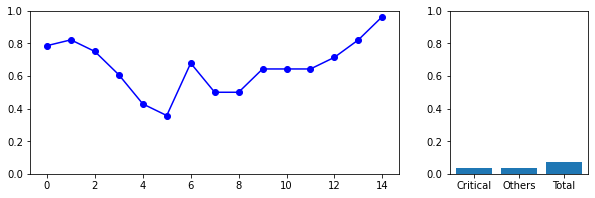

Plotting Serial position graph for subject: 29c
Entry: 29c
Number of distractors recalled/total recalls: 5/284 | 1.761%
Number of critial lure recalls/total distractor recalls: 5/5 | 100.000%


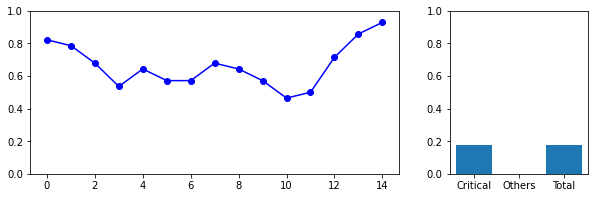

Plotting Serial position graph for subject: 30c
Entry: 30c
Number of distractors recalled/total recalls: 9/194 | 4.639%
Number of critial lure recalls/total distractor recalls: 4/9 | 44.444%


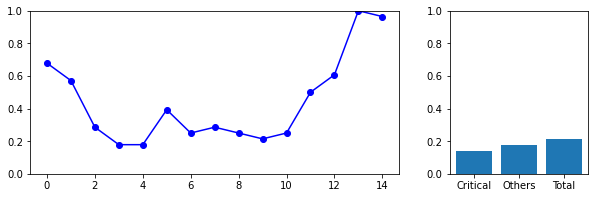

Plotting Serial position graph for subject: 31c
Entry: 31c
Number of distractors recalled/total recalls: 5/278 | 1.799%
Number of critial lure recalls/total distractor recalls: 2/5 | 40.000%


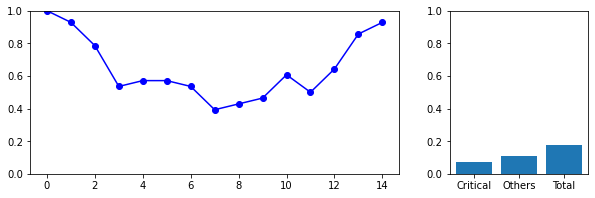

Plotting Serial position graph for subject: 32c
Entry: 32c
Number of distractors recalled/total recalls: 9/247 | 3.644%
Number of critial lure recalls/total distractor recalls: 1/9 | 11.111%


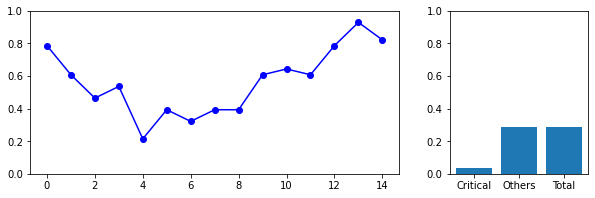

Plotting Serial position graph for subject: 66c
Entry: 66c
Number of distractors recalled/total recalls: 24/265 | 9.057%
Number of critial lure recalls/total distractor recalls: 4/24 | 16.667%


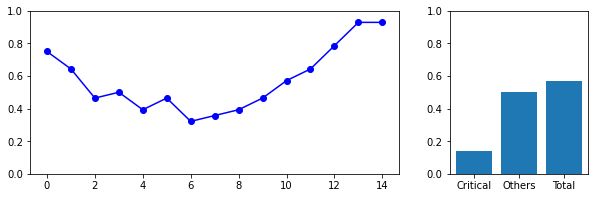

Plotting Serial position graph for subject: 67c
Entry: 67c
Number of distractors recalled/total recalls: 14/245 | 5.714%
Number of critial lure recalls/total distractor recalls: 0/14 | 0.000%


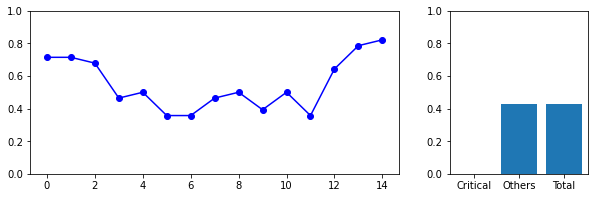

Plotting Serial position graph for subject: 69c
Entry: 69c
Number of distractors recalled/total recalls: 16/282 | 5.674%
Number of critial lure recalls/total distractor recalls: 6/16 | 37.500%


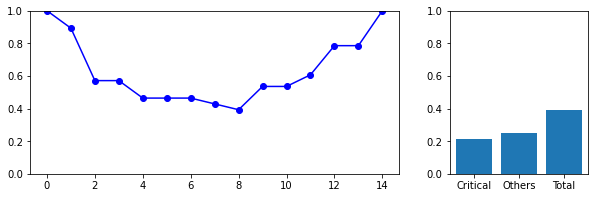

Plotting Serial position graph for subject: 70c
Entry: 70c
Number of distractors recalled/total recalls: 6/297 | 2.020%
Number of critial lure recalls/total distractor recalls: 2/6 | 33.333%


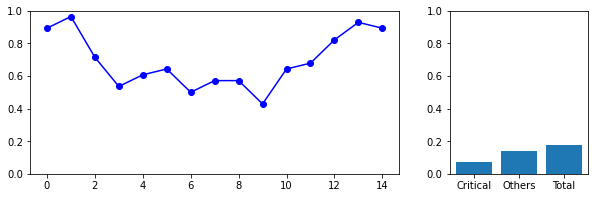

Plotting Serial position graph for subject: 71c
Entry: 71c
Number of distractors recalled/total recalls: 9/235 | 3.830%
Number of critial lure recalls/total distractor recalls: 3/9 | 33.333%


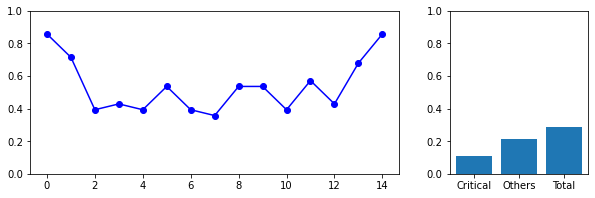

Plotting Serial position graph for subject: 72c
Entry: 72c
Number of distractors recalled/total recalls: 5/150 | 3.333%
Number of critial lure recalls/total distractor recalls: 3/5 | 60.000%


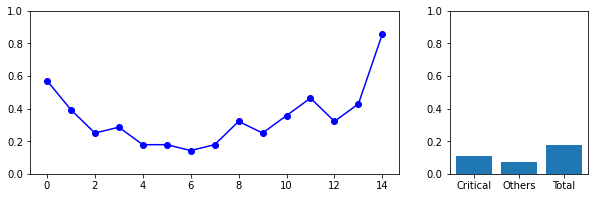

Plotting Serial position graph for subject: 73c
Entry: 73c
Number of distractors recalled/total recalls: 20/234 | 8.547%
Number of critial lure recalls/total distractor recalls: 4/20 | 20.000%


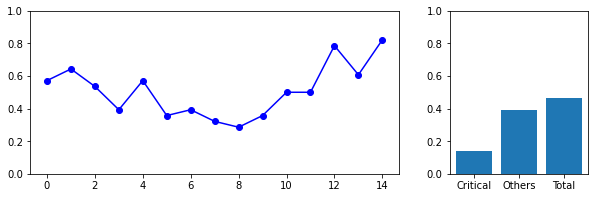

Plotting Serial position graph for subject: 74c
Entry: 74c
Number of distractors recalled/total recalls: 12/297 | 4.040%
Number of critial lure recalls/total distractor recalls: 4/12 | 33.333%


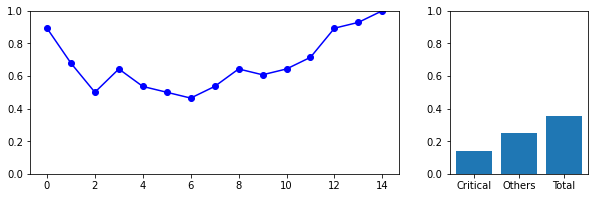

Plotting Serial position graph for subject: 75c
Entry: 75c
Number of distractors recalled/total recalls: 4/288 | 1.389%
Number of critial lure recalls/total distractor recalls: 2/4 | 50.000%


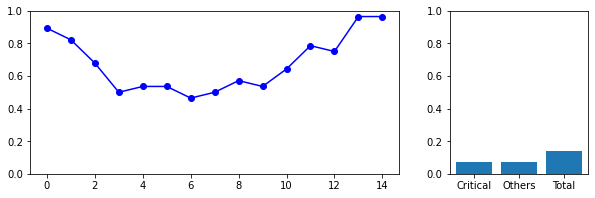

Plotting Serial position graph for subject: 76c
Entry: 76c
Number of distractors recalled/total recalls: 21/273 | 7.692%
Number of critial lure recalls/total distractor recalls: 9/21 | 42.857%


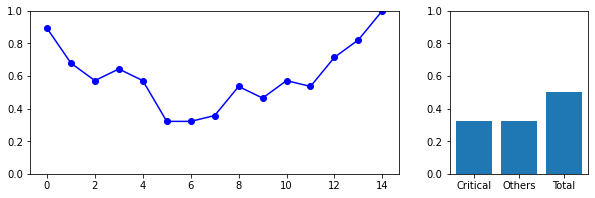

Plotting Serial position graph for subject: 33d
Entry: 33d
Number of distractors recalled/total recalls: 14/287 | 4.878%
Number of critial lure recalls/total distractor recalls: 3/14 | 21.429%


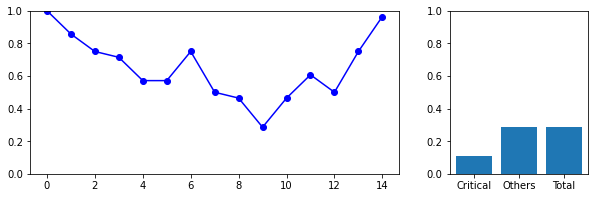

Plotting Serial position graph for subject: 34d
Entry: 34d
Number of distractors recalled/total recalls: 18/375 | 4.800%
Number of critial lure recalls/total distractor recalls: 5/18 | 27.778%


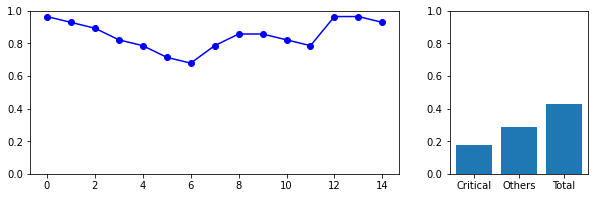

Plotting Serial position graph for subject: 35d
Entry: 35d
Number of distractors recalled/total recalls: 6/332 | 1.807%
Number of critial lure recalls/total distractor recalls: 3/6 | 50.000%


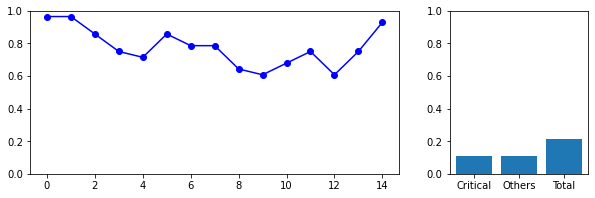

Plotting Serial position graph for subject: 36d
Entry: 36d
Number of distractors recalled/total recalls: 11/279 | 3.943%
Number of critial lure recalls/total distractor recalls: 6/11 | 54.545%


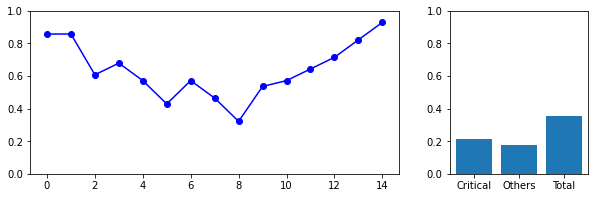

Plotting Serial position graph for subject: 37d
Entry: 37d
Number of distractors recalled/total recalls: 9/242 | 3.719%
Number of critial lure recalls/total distractor recalls: 3/9 | 33.333%


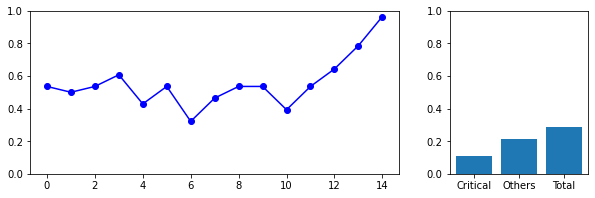

Plotting Serial position graph for subject: 38d
Entry: 38d
Number of distractors recalled/total recalls: 7/227 | 3.084%
Number of critial lure recalls/total distractor recalls: 2/7 | 28.571%


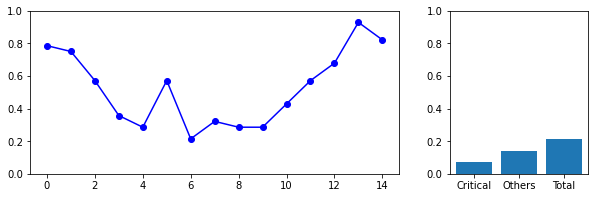

Plotting Serial position graph for subject: 39d
Entry: 39d
Number of distractors recalled/total recalls: 16/238 | 6.723%
Number of critial lure recalls/total distractor recalls: 8/16 | 50.000%


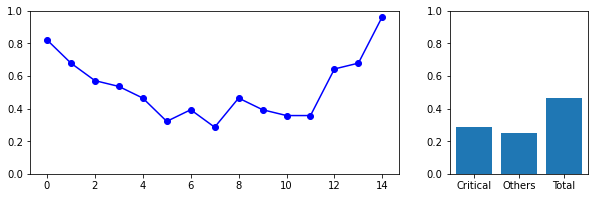

Plotting Serial position graph for subject: 40d
Entry: 40d
Number of distractors recalled/total recalls: 19/292 | 6.507%
Number of critial lure recalls/total distractor recalls: 11/19 | 57.895%


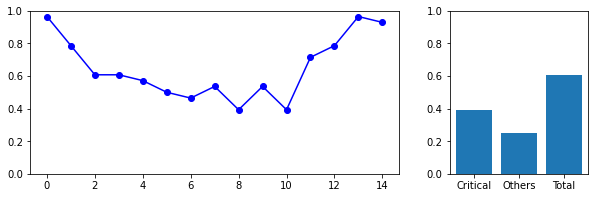

Plotting Serial position graph for subject: 41d
Entry: 41d
Number of distractors recalled/total recalls: 27/253 | 10.672%
Number of critial lure recalls/total distractor recalls: 5/27 | 18.519%


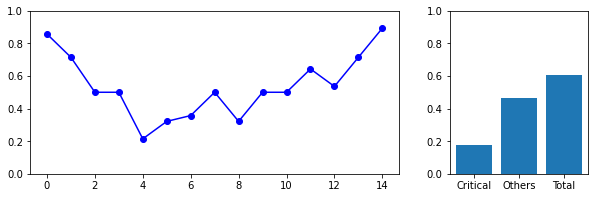

Plotting Serial position graph for subject: 42d
Entry: 42d
Number of distractors recalled/total recalls: 17/334 | 5.090%
Number of critial lure recalls/total distractor recalls: 6/17 | 35.294%


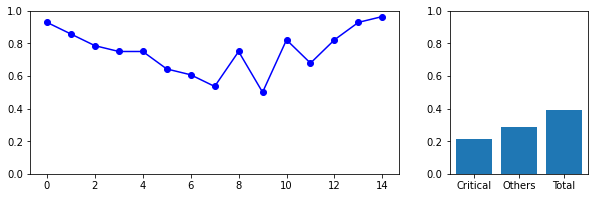

Plotting Serial position graph for subject: 43d
Entry: 43d
Number of distractors recalled/total recalls: 13/241 | 5.394%
Number of critial lure recalls/total distractor recalls: 5/13 | 38.462%


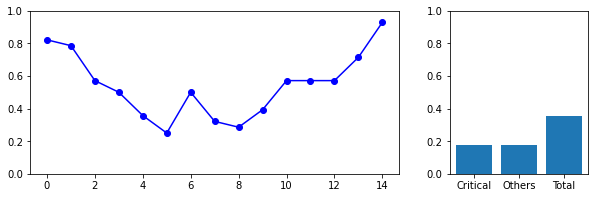

Plotting Serial position graph for subject: 77d
Entry: 77d
Number of distractors recalled/total recalls: 9/351 | 2.564%
Number of critial lure recalls/total distractor recalls: 2/9 | 22.222%


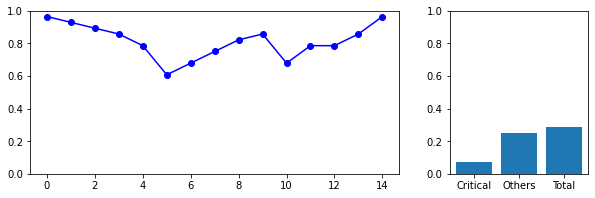

Plotting Serial position graph for subject: 79d
Entry: 79d
Number of distractors recalled/total recalls: 5/226 | 2.212%
Number of critial lure recalls/total distractor recalls: 1/5 | 20.000%


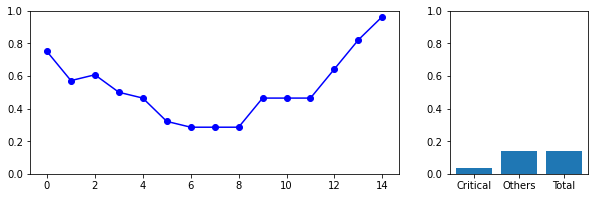

Plotting Serial position graph for subject: 81d
Entry: 81d
Number of distractors recalled/total recalls: 9/294 | 3.061%
Number of critial lure recalls/total distractor recalls: 5/9 | 55.556%


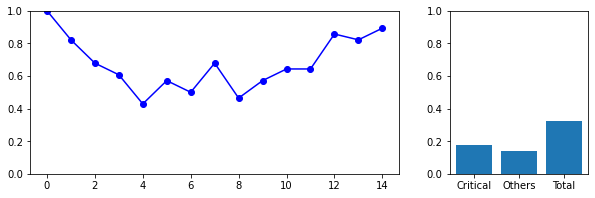

Plotting Serial position graph for subject: 82d
Entry: 82d
Number of distractors recalled/total recalls: 11/283 | 3.887%
Number of critial lure recalls/total distractor recalls: 4/11 | 36.364%


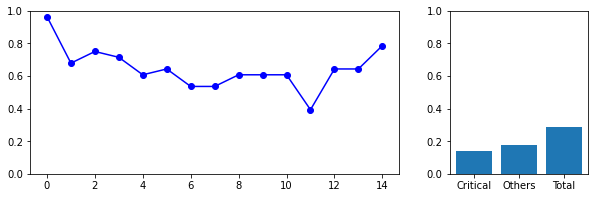

Plotting Serial position graph for subject: 85d
Entry: 85d
Number of distractors recalled/total recalls: 5/267 | 1.873%
Number of critial lure recalls/total distractor recalls: 4/5 | 80.000%


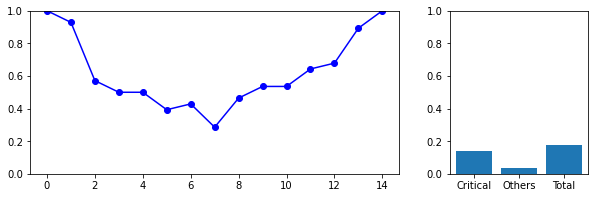

Plotting Serial position graph for subject: 86d
Entry: 86d
Number of distractors recalled/total recalls: 18/281 | 6.406%
Number of critial lure recalls/total distractor recalls: 9/18 | 50.000%


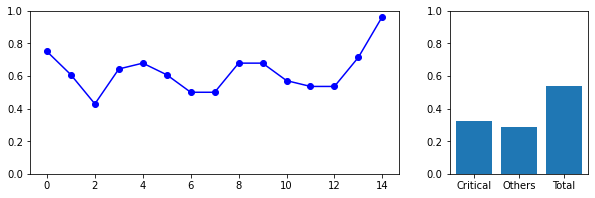

Plotting Serial position graph for subject: 87d
Entry: 87d
Number of distractors recalled/total recalls: 23/290 | 7.931%
Number of critial lure recalls/total distractor recalls: 11/23 | 47.826%


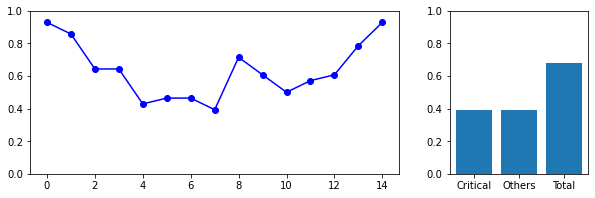

Plotting Serial position graph for subject: 88d
Entry: 88d
Number of distractors recalled/total recalls: 9/239 | 3.766%
Number of critial lure recalls/total distractor recalls: 4/9 | 44.444%


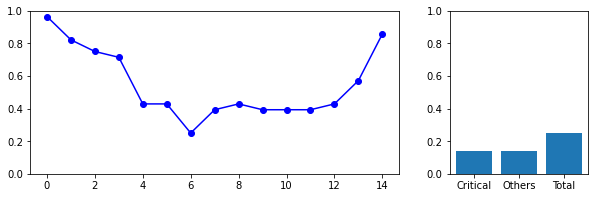

Plotting Serial position graph for subject: 89d
Entry: 89d
Number of distractors recalled/total recalls: 11/280 | 3.929%
Number of critial lure recalls/total distractor recalls: 4/11 | 36.364%


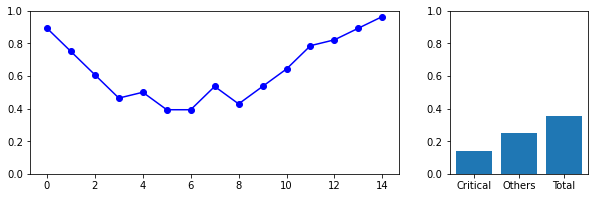

In [11]:
for s in subjects:
    print(f"Plotting Serial position graph for subject: {s}")
    plot_list_recall(get_recall_rate(subject_matrix,s,verbose=True))

### Processing LSA Semantic Information Matrix

Automate a query for lsa cosines from wordlists and parse output into matrix to then load into matlab CMR model

In [12]:
# Parse into LSA web query format (dense matrix of 28*2*(16^2) rows)
# We only query into a diagonal matrix (since within list comparisons are all we need at the moment)
def format_lsa_query(fname):
    with open(fname,'w+') as fout:
        for w in list_order:
            list_words = []
            list_words.append(w)
            list_words.extend(word_lists[w])
            for i in range(len(list_words)):
                for j in range(i+1,len(list_words)):
                    fout.write(f"{list_words[i]}\n\n{list_words[j]}\n\n")

format_lsa_query('lsa_query.txt')

Paste the contents of `lsa_query.txt` into LSA web pairwise comparison interface and copy web output contents into a file, thereafter, run `python extract_lsa_output.py <file_name>` to get .csv with (w1,w2,cosine) on each line.

In [13]:
# Extract the cosine values from each word pair in .csv and load into diagonal sparse matrix
def load_lsa_cosines(fname):
    # Load up word pair cosines into dictionary for lookup
    lsa_dict = dict()
    with open(fname,'r') as fin:
        for line in fin:
            w1,w2,cos = line.strip().split(',')
            cos = float(cos)
            if (w1 not in lsa_dict):
                lsa_dict[w1] = dict()
                lsa_dict[w1][w1] = 1.0
            lsa_dict[w1][w2] = cos
            if (w2 not in lsa_dict):
                lsa_dict[w2] = dict()
                lsa_dict[w2][w2] = 1.0
            lsa_dict[w2][w1] = cos
    # Format semantic matrix for matlab use
    tot_words = 16*len(list_order)
    out_mat = np.zeros((tot_words,tot_words))
    words = []
    for i, crit in enumerate(list_order):
        list_words = [crit]
        list_words.extend(word_lists[crit])
        words.extend(list_words)
        for j in range(16):
            for k in range(16):
                out_mat[j+i*16,k+i*16] = lsa_dict[list_words[j]][list_words[k]]
    return words,out_mat
    
tfr_wp, sem_mat = load_lsa_cosines('lsa_output_output.csv')

# Structure of output matrix:
# list_1  0       ...    0
# 0       list_2  ...    0
# ...     ...     ...    ...
# 0       0       0      list_28
# Each list is a dense sub-matrix with all-pairs comparison within list words
# first row/column in each sub-matrix is the critical lure
print(sem_mat)

[[1.   0.29 0.31 ... 0.   0.   0.  ]
 [0.29 1.   0.22 ... 0.   0.   0.  ]
 [0.31 0.22 1.   ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 1.   0.06 0.57]
 [0.   0.   0.   ... 0.06 1.   0.12]
 [0.   0.   0.   ... 0.57 0.12 1.  ]]


In [14]:
# Save lsa output matrix into .mat for MATLAB use
matlab_data = {'tfr_wp': np.asarray(tfr_wp,dtype='object'), 'sem_mat': sem_mat}
savemat('LSA_drm.mat',matlab_data,oned_as='column')

### Processing word2vec Semantic Information Matrix

Extract embedded vectors from GoogleNews300d pre-trained model and compute cosines for word pairs and parse output into matrix to then load into matlab CMR model

In [15]:
# Extract the word vectors for each word used in the 28 lists and compute cosines with each other
def load_w2v_cosines(fname):
    # Load up word pair cosines into dictionary for lookup
    w2v_vecs = dict()
    w2v_cosines = dict()
    with open(fname,'r') as fin:
        w2v_vecs = json.load(fin)
    exception_list = dict()
    for crit in list_order:
        list_words = [crit]
        list_words.extend(word_lists[crit])
        for i in range(len(list_words)):
            for j in range(i,len(list_words)):
                ow1 = list_words[i]
                ow2 = list_words[j]
                w1 = list_words[i]
                w2 = list_words[j]
                # Making the words capital-insensitive
                if (w1 not in w2v_vecs):
                    exception_list[ow1] = w1.lower()
                    w1 = w1.lower()
                if (w2 not in w2v_vecs):
                    exception_list[ow2] = w2.lower()
                    w2 = w2.lower()
                if (w1 not in w2v_vecs):
                    exception_list[ow1] = w1.upper()
                    w1 = w1.upper()
                if (w2 not in w2v_vecs):
                    exception_list[ow2] = w2.upper()
                    w2 = w2.upper()
                # Compute cosine
                cos = 1-cosine(w2v_vecs[w1],w2v_vecs[w2])
                if (w1 not in w2v_cosines):
                    w2v_cosines[w1] = dict()
                    w2v_cosines[w1][w1] = 1.0
                w2v_cosines[w1][w2] = cos
                if (w2 not in w2v_cosines):
                    w2v_cosines[w2] = dict()
                    w2v_cosines[w2][w2] = 1.0
                w2v_cosines[w2][w1] = cos
    # Format semantic matrix for matlab use
    tot_words = 16*len(list_order)
    out_mat = np.zeros((tot_words,tot_words))
    words = []
    for i, crit in enumerate(list_order):
        list_words = [crit]
        list_words.extend(word_lists[crit])
        list_words = [w if w not in exception_list else exception_list[w] for w in list_words]
        words.extend(list_words)
        for j in range(16):
            w1 = list_words[j]
            for k in range(16):
                w2 = list_words[k]
                try:
                    out_mat[j+i*16,k+i*16] = w2v_cosines[w1][w2]
                except Exception as e:
                    print(e)
                    print(w1, w2)
    return words,out_mat

# Load from json document with {word: [vec]} dictionary
w2v_tfr_wp, w2v_sem_mat = load_w2v_cosines('drm_28lists.json')

# Structure of output matrix:
# list_1  0       ...    0
# 0       list_2  ...    0
# ...     ...     ...    ...
# 0       0       0      list_28
# Each list is a dense sub-matrix with all-pairs comparison within list words
# first row/column in each sub-matrix is the critical lure
print(w2v_sem_mat)

[[1.         0.39144116 0.24191801 ... 0.         0.         0.        ]
 [0.39144116 1.         0.12207348 ... 0.         0.         0.        ]
 [0.24191801 0.12207348 1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.12422301 0.26942074]
 [0.         0.         0.         ... 0.12422301 1.         0.02354809]
 [0.         0.         0.         ... 0.26942074 0.02354809 1.        ]]


In [16]:
# Save w2v output matrix into .mat for MATLAB use
matlab_data = {'tfr_wp': np.asarray(w2v_tfr_wp,dtype='object'), 'sem_mat': w2v_sem_mat}
savemat('w2v_drm.mat',matlab_data,oned_as='column')

# Using CMR framework to simulate free recall task with distractors

In the following section, we use the [CMR framework](http://memory.psych.upenn.edu/CMR) to generate free recall data on these 28 lists under two conditions: using LSA and word2vec semantic knowledge bases.

Parameters from M62 free recall task as reported in the 2009 paper (Poly et.al) is used for this experiment

## LSA Simulation Results

In [17]:
# Load up our matlab simulation output
cmr_results = dict()
loadmat('cmr_drm.mat',cmr_results,mat_dtype=True)
cmr_list_data = cmr_results['data'][0][0][0][0]
cmr_list_data = {w: cmr_list_data[i][0].transpose() for i, w in enumerate(list_order)}
# We now have for our cmr simulated free recall tasks, subject responses to list item recall (in order)
# per column stored as a matrix in each key of dictionary (corresponding to list critical item)
# A '-1' stands for critical lure recall
print(cmr_list_data['rubber'])

[[-1. 15. -1. ... 15. 11. 13.]
 [15. 13. 11. ... 13. 15. 14.]
 [11. 11. 12. ... -1. 12. 15.]
 ...
 [ 0.  0.  0. ...  0.  0.  2.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]


### Visualization & Correlation with behavioral data

Next, we reformat the output matrix into the same format as collected behavioral data and run our visualizations once more

In [18]:
# Save output matrix as .csv in same format as input behavior data to quickly reuse workflow
# Given list_matrix processed above from matlab data
def save_matlab_output(fname,li_mat):
    num_subjects = len(li_mat[list_order[0]][0,:])
    with open(fname,'w+') as fout:
        # Write header
        fout.write("Subject,words," + ",".join([str(i) for i in range(1,num_subjects+1)]) + "\n")
        # Process each list
        for crit in list_order:
            # Reformat list matrix
            list_mat = np.zeros((16,num_subjects),dtype=np.int32)
            for s in range(num_subjects):
                for i, item in enumerate(li_mat[crit][:,s]):
                    item = safe_int(item)
                    if (item == -1):
                        list_mat[0,s] = i+1
                    elif (item > 0):
                        list_mat[item,s] = i+1
            # Write first critical lure line
            fout.write(f"CL,{crit}," + ",".join([str(i) for i in list_mat[0,:]]) + "\n")
            # Dump list matrix to file
            for r, w in enumerate(word_lists[crit]):
                fout.write(f"{r+1},{w}," + ",".join([str(i) for i in list_mat[r+1,:]]) + "\n")
            # Dummy last line
            fout.write(f"othr,," + "0,"*(num_subjects-1) + "0" + "\n")
        
save_matlab_output('raw_cmr_data.csv',cmr_list_data)

### Reformat our matlab simulation data to visualize

In [19]:
# Simulated CMR Data
cmr_subjects, cmr_list_order, cmr_word_lists, cmr_recall_data, cmr_list_data, cmr_subject_matrix, cmr_list_matrix = load_data("raw_cmr_data.csv")

### Run our above visualizations on matlab data

Entry: rough
Number of distractors recalled/total recalls: 100/946 | 10.571%
Number of critial lure recalls/total distractor recalls: 100/100 | 100.000%


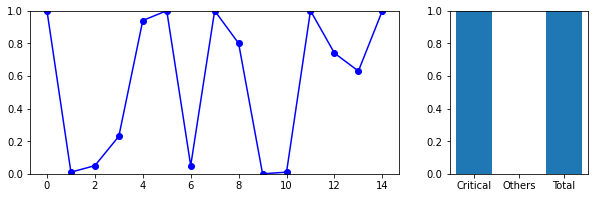

Serial position data for all lists (aggregated across subjects)


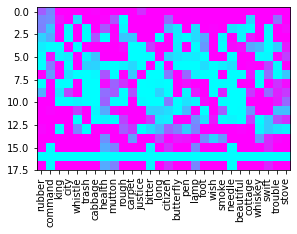

Serial position data for all subjects (aggregated across lists)


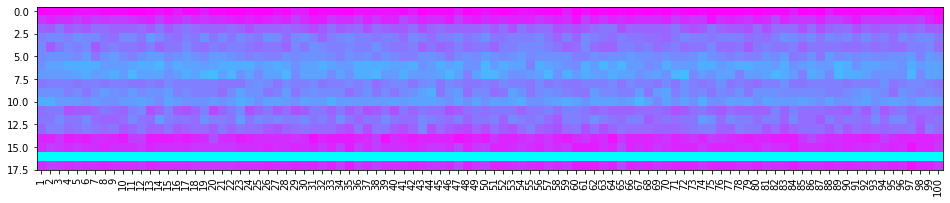

In [20]:
# Serial position curve for the 'rough' list
plot_list_recall(get_recall_rate(cmr_list_matrix,"rough",verbose=True))
# Matrix heatmap for all lists
print("Serial position data for all lists (aggregated across subjects)")
plot_matrix_heatmap(format_recall_matrix(cmr_list_matrix,cmr_list_order),cmr_list_order)

# Matrix heatmap for all subjects
# For CMR experimental data, presentation orders are identity,
# only between-subject differences will be accumulator noise added
print("Serial position data for all subjects (aggregated across lists)")
plot_matrix_heatmap(format_recall_matrix(cmr_subject_matrix,cmr_subjects),keylist=cmr_subjects,size=(20,3))

### Comparison of lists recall performance between Behavioral and CMR model

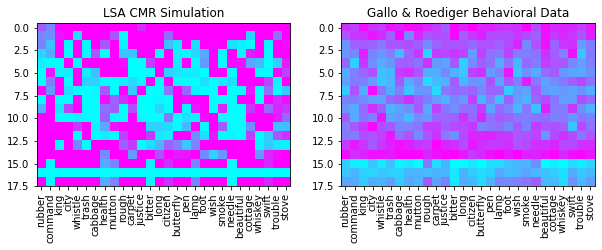

In [21]:
# Matrix heatmap for all lists
f,axes = plt.subplots(1,2,figsize=(10,3))
plt.sca(axes[0])
axes[0].title.set_text("LSA CMR Simulation")
plt.xticks(ticks=range(len(cmr_list_order)),labels=cmr_list_order,rotation=90)
plt.imshow(format_recall_matrix(cmr_list_matrix,cmr_list_order),cmap='cool',interpolation='nearest')
plt.sca(axes[1])
axes[1].title.set_text("Gallo & Roediger Behavioral Data")
plt.xticks(ticks=range(len(list_order)),labels=list_order,rotation=90)
plt.imshow(format_recall_matrix(list_matrix,list_order),cmap='cool',interpolation='nearest')
plt.show()

Plotting Serial position graph for list: rubber
Entry: rubber
Number of distractors recalled/total recalls: 100/914 | 10.941%
Number of critial lure recalls/total distractor recalls: 100/100 | 100.000%


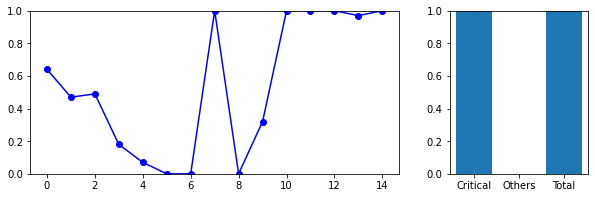

Plotting Serial position graph for list: command
Entry: command
Number of distractors recalled/total recalls: 2/1031 | 0.194%
Number of critial lure recalls/total distractor recalls: 2/2 | 100.000%


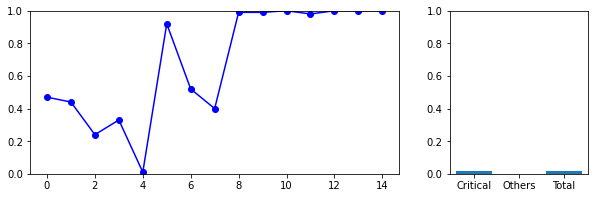

Plotting Serial position graph for list: king
Entry: king
Number of distractors recalled/total recalls: 100/1008 | 9.921%
Number of critial lure recalls/total distractor recalls: 100/100 | 100.000%


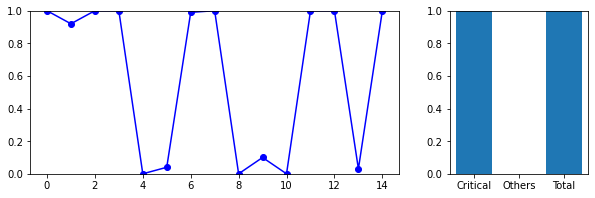

Plotting Serial position graph for list: city
Entry: city
Number of distractors recalled/total recalls: 100/894 | 11.186%
Number of critial lure recalls/total distractor recalls: 100/100 | 100.000%


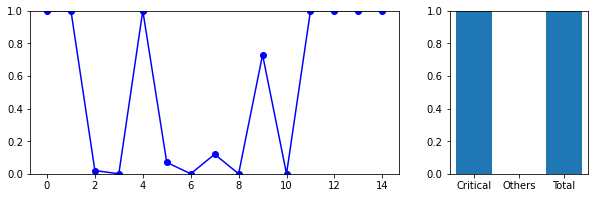

Plotting Serial position graph for list: whistle
Entry: whistle
Number of distractors recalled/total recalls: 100/1041 | 9.606%
Number of critial lure recalls/total distractor recalls: 100/100 | 100.000%


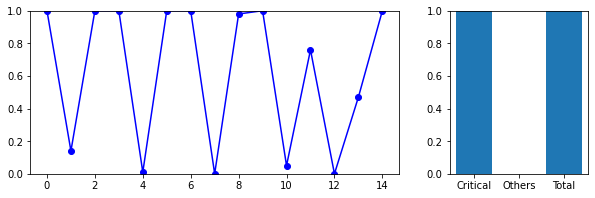

Plotting Serial position graph for list: trash
Entry: trash
Number of distractors recalled/total recalls: 100/726 | 13.774%
Number of critial lure recalls/total distractor recalls: 100/100 | 100.000%


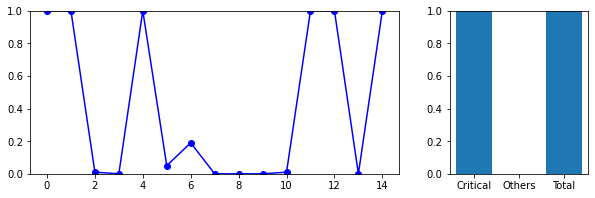

Plotting Serial position graph for list: cabbage
Entry: cabbage
Number of distractors recalled/total recalls: 100/813 | 12.300%
Number of critial lure recalls/total distractor recalls: 100/100 | 100.000%


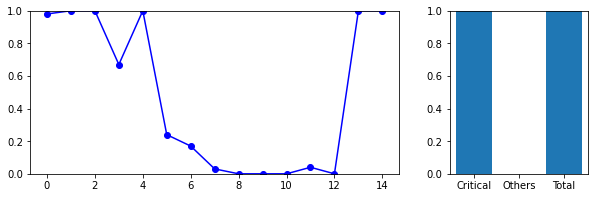

Plotting Serial position graph for list: health
Entry: health
Number of distractors recalled/total recalls: 33/960 | 3.438%
Number of critial lure recalls/total distractor recalls: 33/33 | 100.000%


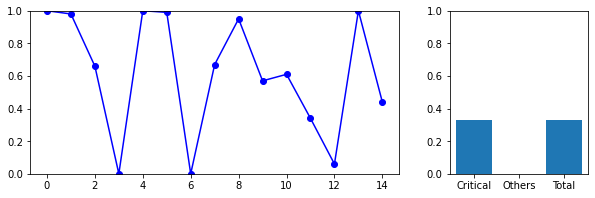

Plotting Serial position graph for list: mutton
Entry: mutton
Number of distractors recalled/total recalls: 49/1032 | 4.748%
Number of critial lure recalls/total distractor recalls: 49/49 | 100.000%


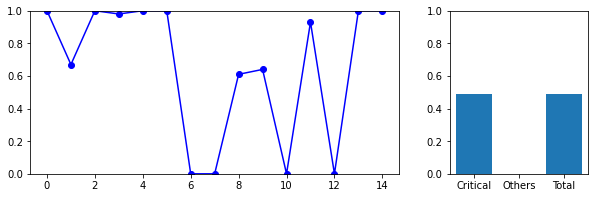

Plotting Serial position graph for list: rough
Entry: rough
Number of distractors recalled/total recalls: 100/946 | 10.571%
Number of critial lure recalls/total distractor recalls: 100/100 | 100.000%


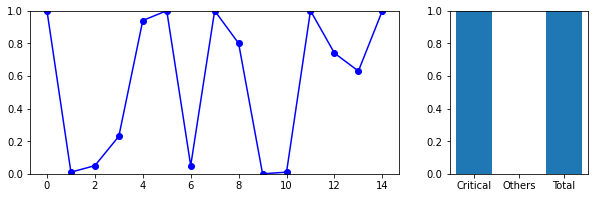

Plotting Serial position graph for list: carpet
Entry: carpet
Number of distractors recalled/total recalls: 100/1043 | 9.588%
Number of critial lure recalls/total distractor recalls: 100/100 | 100.000%


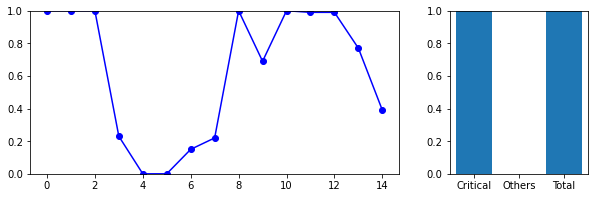

Plotting Serial position graph for list: justice
Entry: justice
Number of distractors recalled/total recalls: 100/884 | 11.312%
Number of critial lure recalls/total distractor recalls: 100/100 | 100.000%


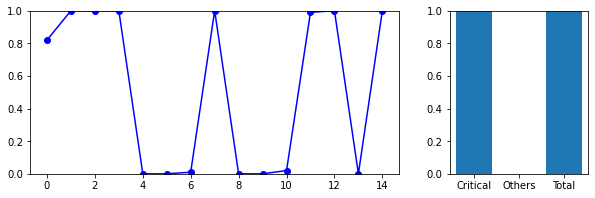

Plotting Serial position graph for list: bitter
Entry: bitter
Number of distractors recalled/total recalls: 5/790 | 0.633%
Number of critial lure recalls/total distractor recalls: 5/5 | 100.000%


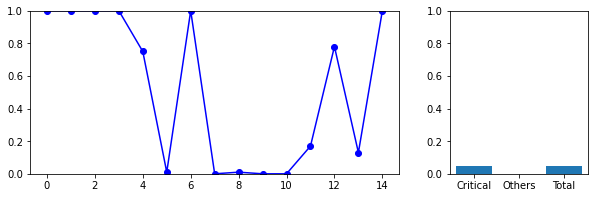

Plotting Serial position graph for list: long
Entry: long
Number of distractors recalled/total recalls: 100/745 | 13.423%
Number of critial lure recalls/total distractor recalls: 100/100 | 100.000%


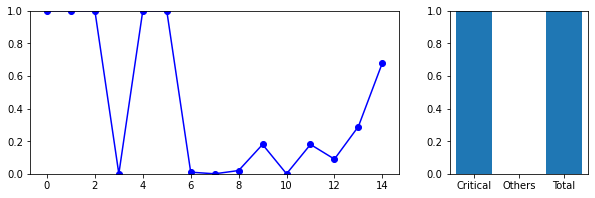

Plotting Serial position graph for list: citizen
Entry: citizen
Number of distractors recalled/total recalls: 81/868 | 9.332%
Number of critial lure recalls/total distractor recalls: 81/81 | 100.000%


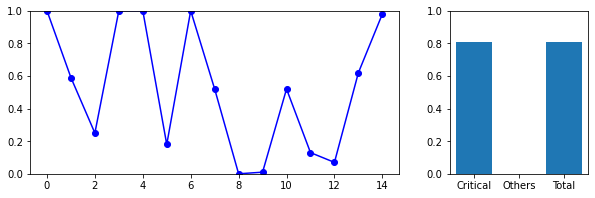

Plotting Serial position graph for list: butterfly
Entry: butterfly
Number of distractors recalled/total recalls: 100/873 | 11.455%
Number of critial lure recalls/total distractor recalls: 100/100 | 100.000%


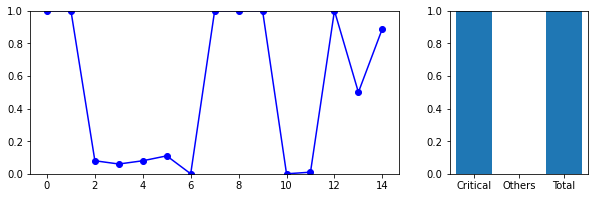

Plotting Serial position graph for list: pen
Entry: pen
Number of distractors recalled/total recalls: 100/913 | 10.953%
Number of critial lure recalls/total distractor recalls: 100/100 | 100.000%


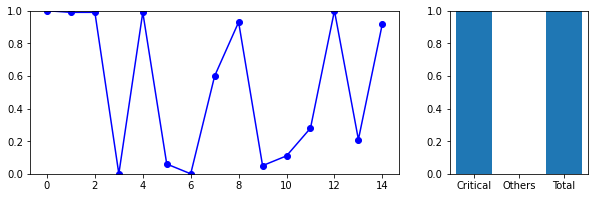

Plotting Serial position graph for list: lamp
Entry: lamp
Number of distractors recalled/total recalls: 48/779 | 6.162%
Number of critial lure recalls/total distractor recalls: 48/48 | 100.000%


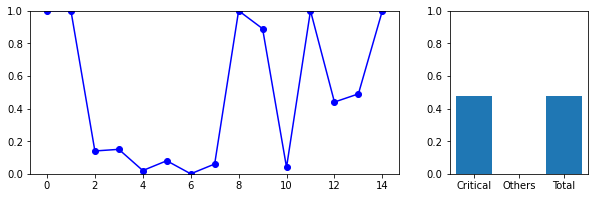

Plotting Serial position graph for list: foot
Entry: foot
Number of distractors recalled/total recalls: 100/940 | 10.638%
Number of critial lure recalls/total distractor recalls: 100/100 | 100.000%


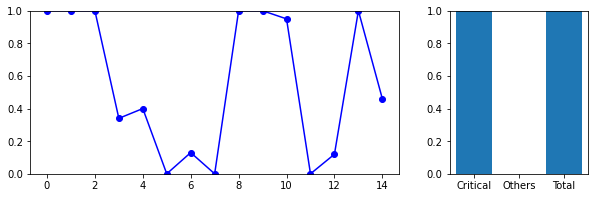

Plotting Serial position graph for list: wish
Entry: wish
Number of distractors recalled/total recalls: 100/1106 | 9.042%
Number of critial lure recalls/total distractor recalls: 100/100 | 100.000%


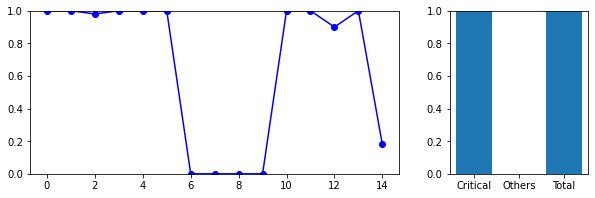

Plotting Serial position graph for list: smoke
Entry: smoke
Number of distractors recalled/total recalls: 100/901 | 11.099%
Number of critial lure recalls/total distractor recalls: 100/100 | 100.000%


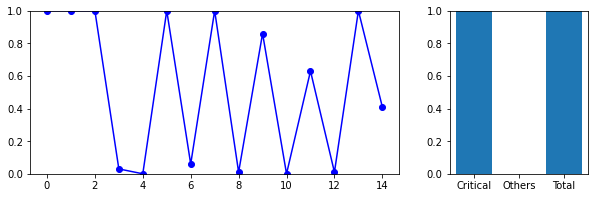

Plotting Serial position graph for list: needle
Entry: needle
Number of distractors recalled/total recalls: 0/626 | 0.000%
Number of critial lure recalls/total distractor recalls: NONE


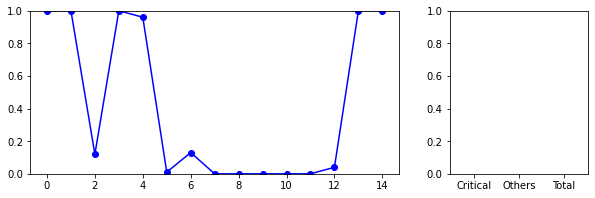

Plotting Serial position graph for list: beautiful
Entry: beautiful
Number of distractors recalled/total recalls: 100/902 | 11.086%
Number of critial lure recalls/total distractor recalls: 100/100 | 100.000%


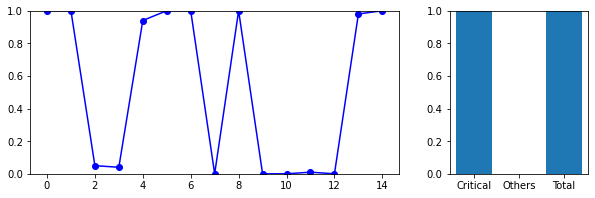

Plotting Serial position graph for list: cottage
Entry: cottage
Number of distractors recalled/total recalls: 100/1227 | 8.150%
Number of critial lure recalls/total distractor recalls: 100/100 | 100.000%


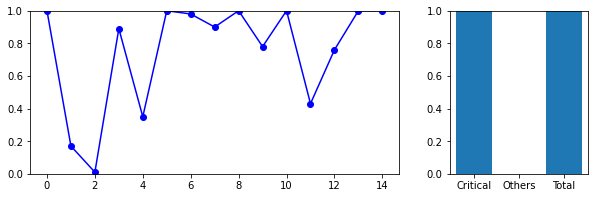

Plotting Serial position graph for list: whiskey
Entry: whiskey
Number of distractors recalled/total recalls: 100/976 | 10.246%
Number of critial lure recalls/total distractor recalls: 100/100 | 100.000%


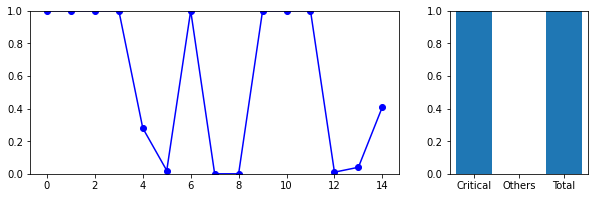

Plotting Serial position graph for list: swift
Entry: swift
Number of distractors recalled/total recalls: 85/906 | 9.382%
Number of critial lure recalls/total distractor recalls: 85/85 | 100.000%


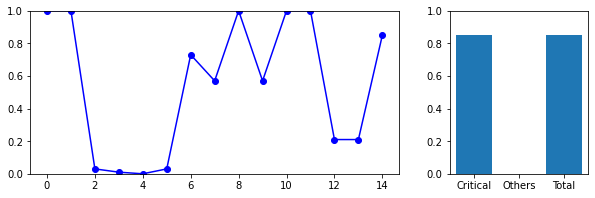

Plotting Serial position graph for list: trouble
Entry: trouble
Number of distractors recalled/total recalls: 100/1029 | 9.718%
Number of critial lure recalls/total distractor recalls: 100/100 | 100.000%


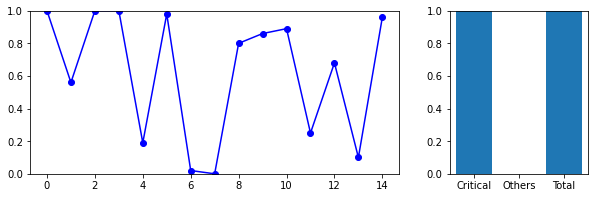

Plotting Serial position graph for list: stove
Entry: stove
Number of distractors recalled/total recalls: 100/1223 | 8.177%
Number of critial lure recalls/total distractor recalls: 100/100 | 100.000%


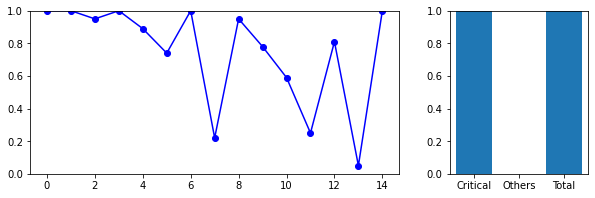

In [22]:
# Detailed plots for each list
for w in cmr_list_order:
    print(f"Plotting Serial position graph for list: {w}")
    plot_list_recall(get_recall_rate(cmr_list_matrix,w,verbose=True))

## Word2vec Simulation Results

In [23]:
# Load up our matlab simulation output similar to LSA procedure
cmr_w2v_results = dict()
loadmat('cmr_w2v_drm.mat',cmr_w2v_results,mat_dtype=True)
cmr_w2v_list_data = cmr_w2v_results['data'][0][0][0][0]
cmr_w2v_list_data = {w: cmr_w2v_list_data[i][0].transpose() for i, w in enumerate(list_order)}
# We now have for our cmr simulated free recall tasks, subject responses to list item recall (in order)
# per column stored as a matrix in each key of dictionary (corresponding to list critical item)
# A '-1' stands for critical lure recall
print(cmr_w2v_list_data['rubber'])
# Save a formatted .csv with w2v semantic matrix simulation
save_matlab_output('raw_cmr_w2v_data.csv',cmr_w2v_list_data)
# Simulated CMR (w2v) Data
cmr_w2v_subjects, cmr_w2v_list_order, cmr_w2v_word_lists, cmr_w2v_recall_data, cmr_w2v_list_data, cmr_w2v_subject_matrix, cmr_w2v_list_matrix = load_data("raw_cmr_w2v_data.csv")

[[14. 14.  1. ... 14. 15. 15.]
 [-1. 15. 13. ... 15. 14. 14.]
 [12.  2. 11. ... 13.  1.  1.]
 ...
 [ 0.  0.  0. ...  9.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]


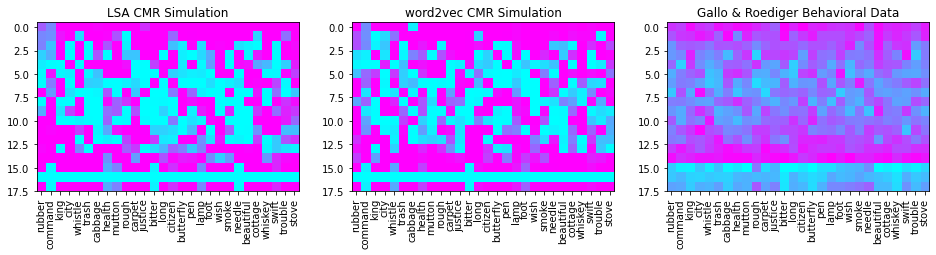

In [24]:
# Matrix heatmap for all lists
f,axes = plt.subplots(1,3,figsize=(16,4))
plt.sca(axes[0])
axes[0].title.set_text("LSA CMR Simulation")
plt.xticks(ticks=range(len(cmr_list_order)),labels=cmr_list_order,rotation=90)
plt.imshow(format_recall_matrix(cmr_list_matrix,cmr_list_order),cmap='cool',interpolation='nearest')
plt.sca(axes[1])
axes[1].title.set_text("word2vec CMR Simulation")
plt.xticks(ticks=range(len(cmr_w2v_list_order)),labels=cmr_w2v_list_order,rotation=90)
plt.imshow(format_recall_matrix(cmr_w2v_list_matrix,cmr_w2v_list_order),cmap='cool',interpolation='nearest')
plt.sca(axes[2])
axes[2].title.set_text("Gallo & Roediger Behavioral Data")
plt.xticks(ticks=range(len(list_order)),labels=list_order,rotation=90)
plt.imshow(format_recall_matrix(list_matrix,list_order),cmap='cool',interpolation='nearest')
plt.show()

### Preliminary Analysis

We observe that the LSA and word2vec results are comparable in its deterministic nature of recall simulation. Although word2vec appears to generate greater frequency of recall. Furthermore, a greater proportion of lists using word2vec semantic matrix exhibits false recall as compared to using LSA semantic matrix.

In addition, the CMR simulation results appears to be highly deterministic and show little variation among simulated trials (as expected since only small pertubations are added as random noise in accumulation step) unlike behavioral results. In the simulation, many terms are either fully (100%) recalled in all trials or not recalled at all.

In the next section, we confirm our suspicions that the semantic force of word connections is what's driving false recall and recall of list items.

### Side-track: What's the squared-error between the diagrams above?

Below, we plot the squared-error matrix between LSA-word2vec, LSA-behavioral, and word2vec-behavioral.

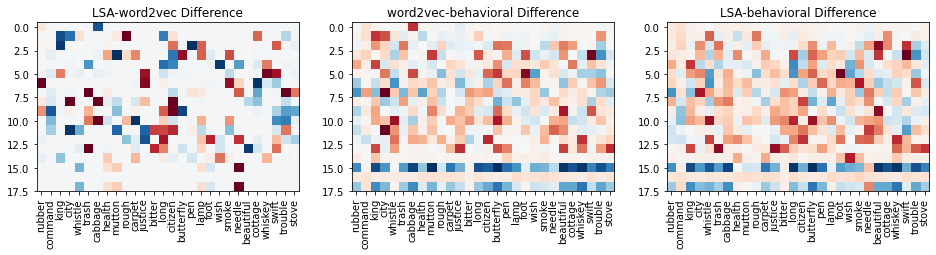

In [25]:
# Matrices for LSA,word2vec,behavioral data
lsa_mat = format_recall_matrix(cmr_list_matrix,cmr_list_order)
w2v_mat = format_recall_matrix(cmr_w2v_list_matrix,cmr_w2v_list_order)
behavioral_mat = format_recall_matrix(list_matrix,list_order)

f,axes = plt.subplots(1,3,figsize=(16,4))
# LSA-word2vec squared difference (preserving sign)
plt.sca(axes[0])
axes[0].title.set_text("LSA-word2vec Difference")
plt.xticks(ticks=range(len(cmr_list_order)),labels=list_order,rotation=90)
diff_mat = lsa_mat-w2v_mat
plt.imshow(np.multiply(np.sign(diff_mat),np.square(diff_mat)),cmap='RdBu',interpolation='nearest')
# word2vec-behavioral squared difference
plt.sca(axes[1])
axes[1].title.set_text("word2vec-behavioral Difference")
plt.xticks(ticks=range(len(cmr_w2v_list_order)),labels=list_order,rotation=90)
diff_mat = w2v_mat-behavioral_mat
plt.imshow(np.multiply(np.sign(diff_mat),np.square(diff_mat)),cmap='RdBu',interpolation='nearest')
# LSA-behavioral squared difference
plt.sca(axes[2])
axes[2].title.set_text("LSA-behavioral Difference")
plt.xticks(ticks=range(len(list_order)),labels=list_order,rotation=90)
diff_mat = lsa_mat-behavioral_mat
plt.imshow(np.multiply(np.sign(diff_mat),np.square(diff_mat)),cmap='RdBu',interpolation='nearest')
plt.show()

In the above plots, we use a Red-Blue color map with the following value mapping:

- Intensity of colors represent magnitude of values
- <0 Negative values are represented by <span style='color:#FF0000'>**Red**</span>
- \>0 Positive values are represented by <span style='color:#0000FF'>**Blue**</span>
- ~0 Values close to 0 are lightly shaded, close to <span style='color:#CCCCCC'>**White**</span>

Each plot is labeled with the direction of subtraction (for instance last plot is generated by subtracting values in the bahavioral matrix *from* the LSA matrix).

As we can see above, the difference in simulated results between using LSA and word2vec are not very different, however, in regions where they are different, perhaps this difference should be in cosine values within lists for those items (which we will confirm in the next section). Furthermore, comparing either set of simulation data against the behavioral results, we see that there are two regions of difference.
- The first region is mostly distributed around the middle of the list where the CMR simulation consistently **under-recalls list items near the middle**.
- The second region is the region of false recalls (last 3 rows) where the CMR simulation consistently **over-recalls critical lure items**

*At this point, before dismissing CMR simulation as inaccurate, we should note that the parameters used for this simulation are those which have been determined to fit random lists drawn from the Murdock,1962 set. A fair comparison would require us to run the same parameter fit on these 28 lists instead using the reported Genetic Algorithm in Poly et.al 2009.*

## Analysis of semantic structure within lists

First, we take a look at both the LSA and word2vec semantic connectivity within list items and compute the correlation of recall probability to overall strength of connection with other list items. To get an initial sense of how interconnected are the lists, we simply plot the matrix of cosines for each list.

In [26]:
# Generate matrices for cosines within each list
list_w2v_mat = {crit: np.zeros((len(word_lists[crit])+1, len(word_lists[crit])+1)) for crit in list_order}
list_lsa_mat = {crit: np.zeros((len(word_lists[crit])+1, len(word_lists[crit])+1)) for crit in list_order}

txy = 0 #To track where in diagonal matrix our local list matrix starts
for crit in list_order:
    etxy = txy+len(word_lists[crit])+1
    list_lsa_mat[crit] = sem_mat[txy:etxy,txy:etxy]
    list_w2v_mat[crit] = w2v_sem_mat[txy:etxy,txy:etxy]
    txy = etxy

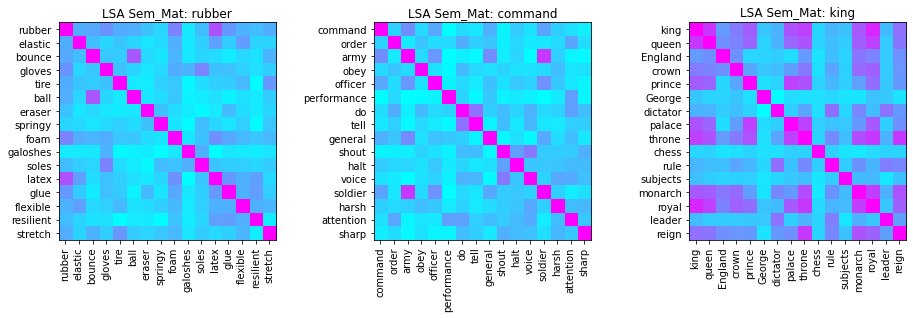

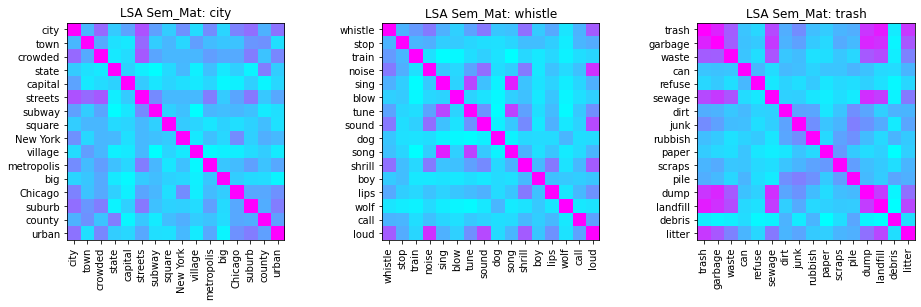

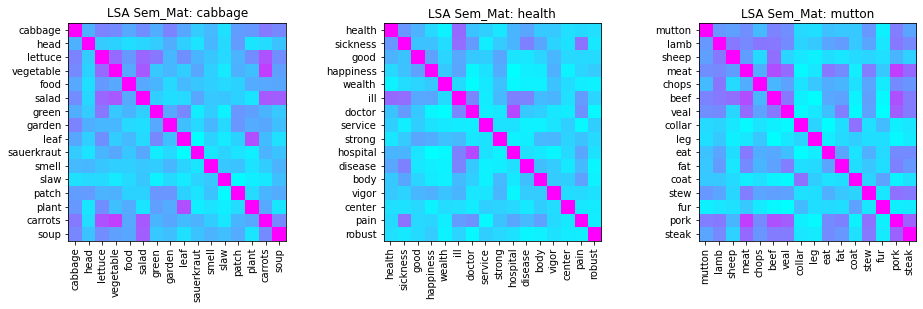

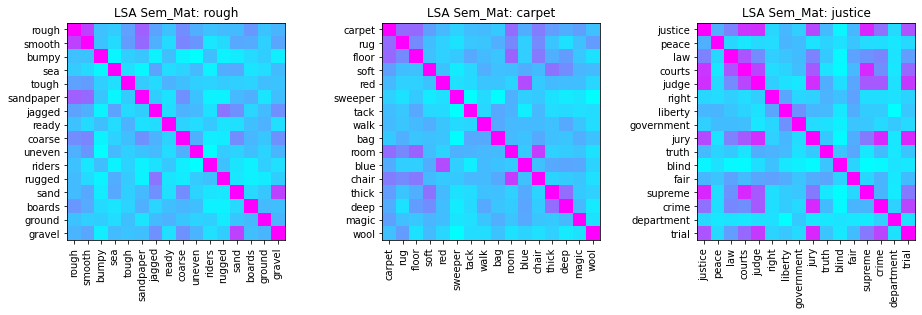

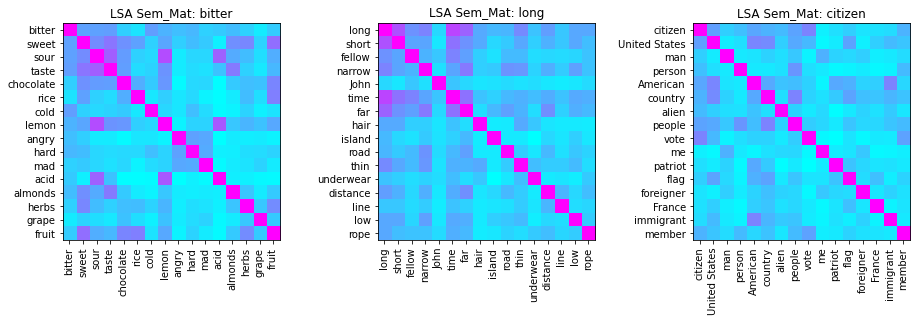

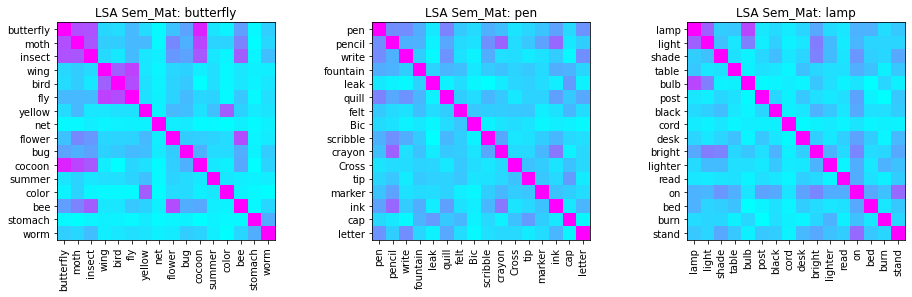

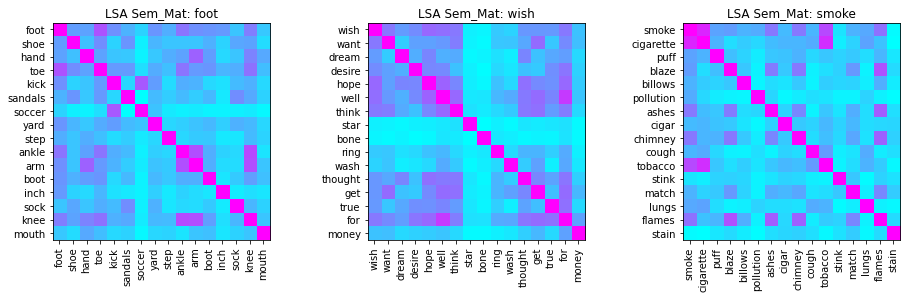

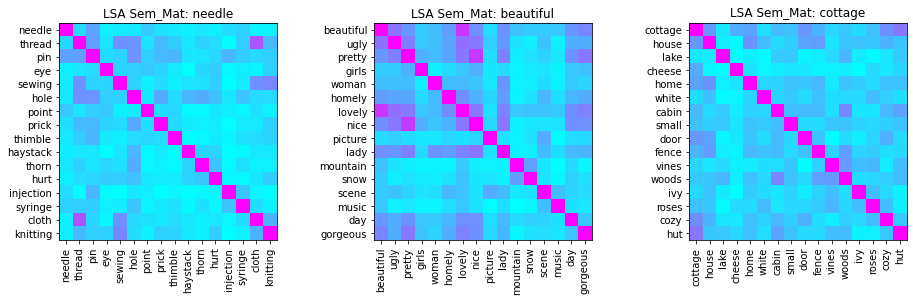

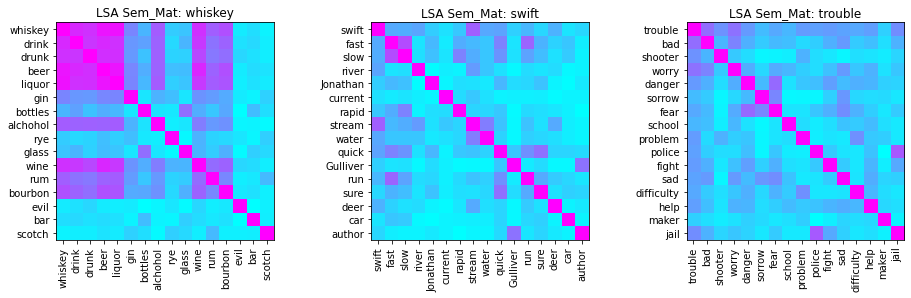

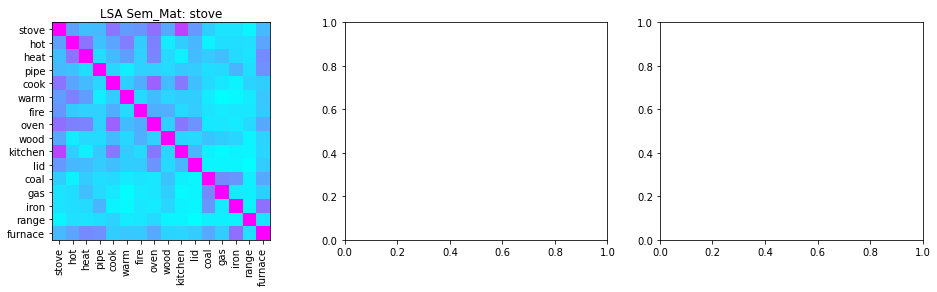

In [27]:
# Plot for LSA Semantic Matrices
num_col = 3
x = 0
for i, crit in enumerate(list_order):
    x = i%num_col
    if (i%num_col == 0):
        plt.show()
        f,axes = plt.subplots(1,num_col,figsize=(16,4))
    cur_list_words = [crit] + word_lists[crit]
    plt.sca(axes[x])
    plt.xticks(ticks=range(len(cur_list_words)),labels=cur_list_words,rotation=90)
    plt.yticks(ticks=range(len(cur_list_words)),labels=cur_list_words)
    axes[x].title.set_text(f"LSA Sem_Mat: {crit}")
    plt.imshow(list_lsa_mat[crit],cmap='cool',interpolation='nearest')
plt.show()

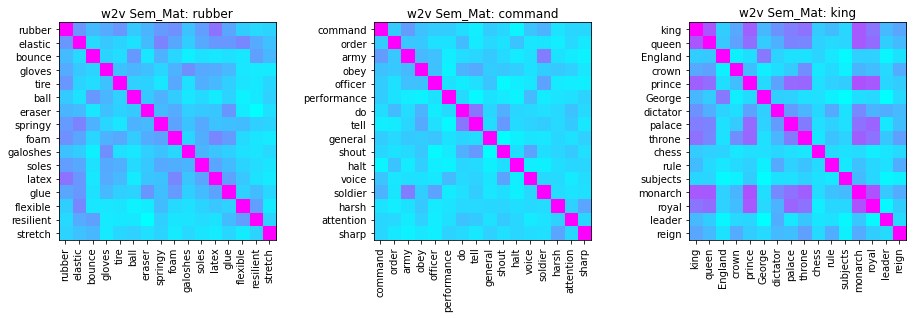

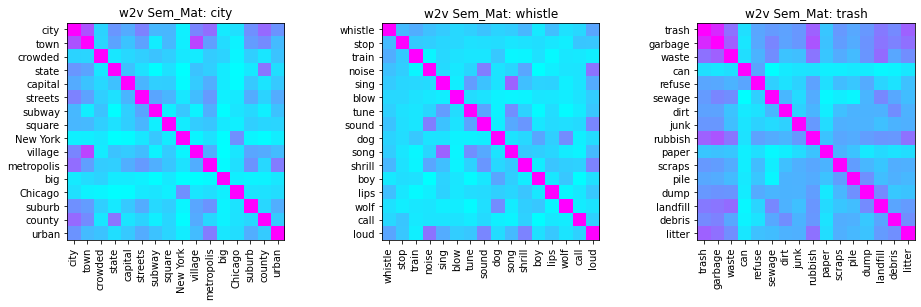

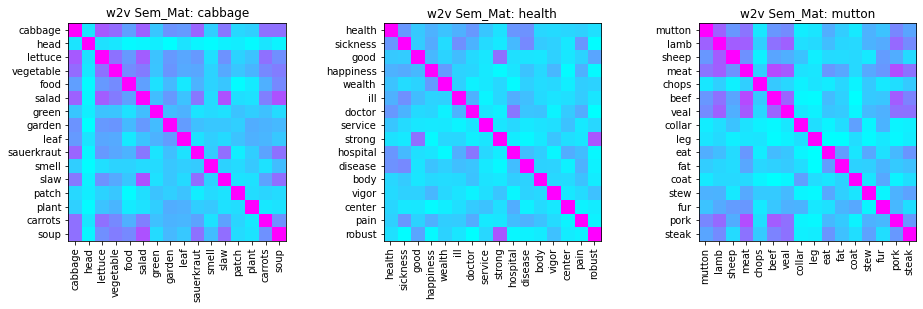

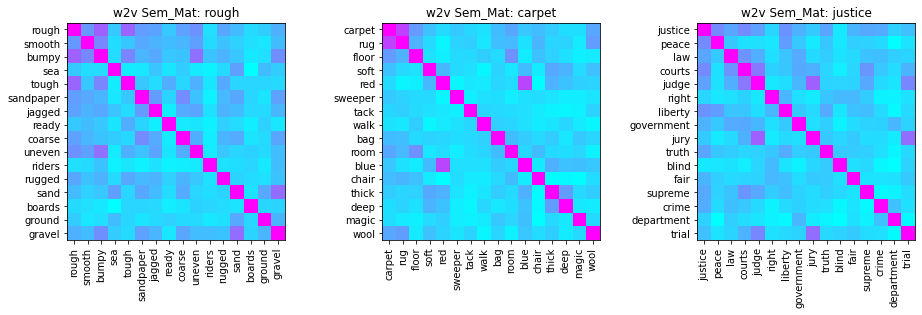

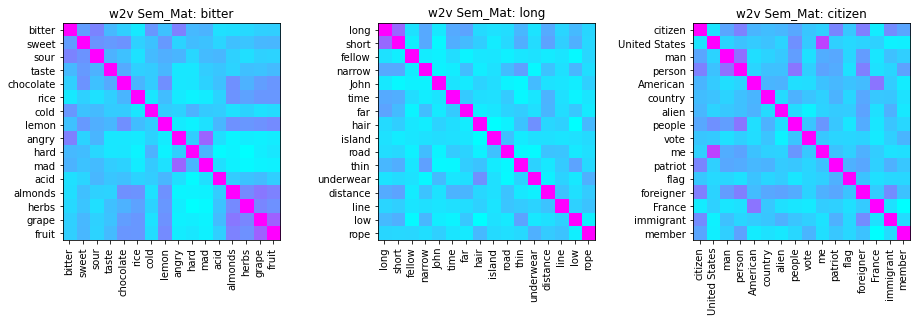

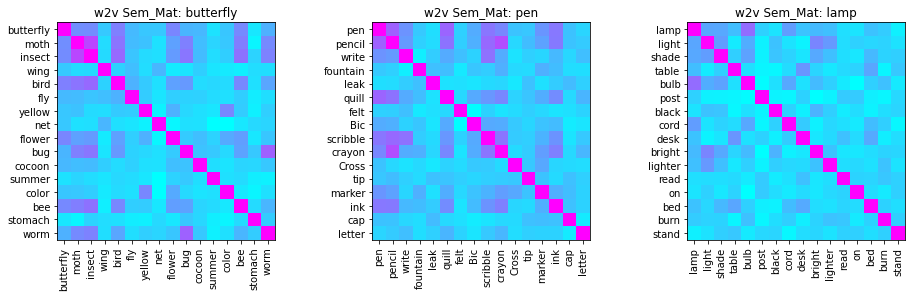

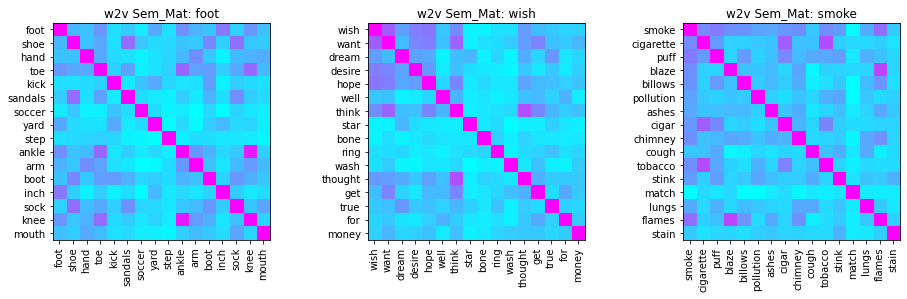

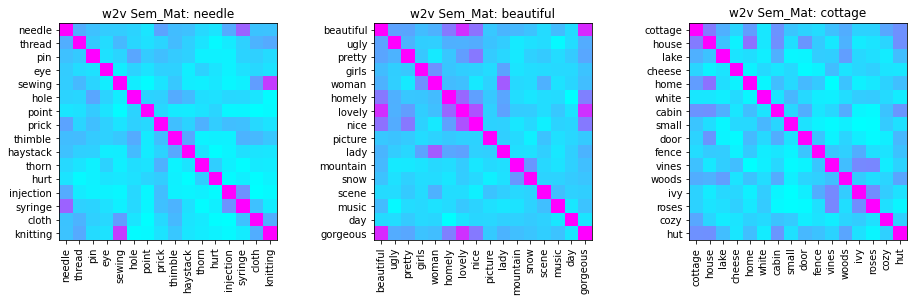

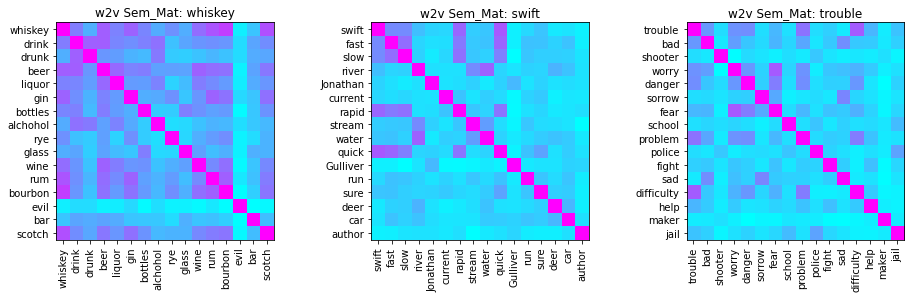

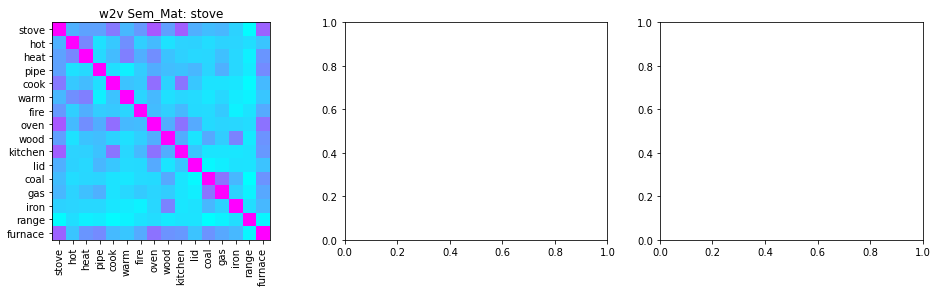

In [28]:
# Plot for word2vec Semantic Matrices
num_col = 3
x = 0
for i, crit in enumerate(list_order):
    x = i%num_col
    if (i%num_col == 0):
        plt.show()
        f,axes = plt.subplots(1,num_col,figsize=(16,4))
    cur_list_words = [crit] + word_lists[crit]
    plt.sca(axes[x])
    plt.xticks(ticks=range(len(cur_list_words)),labels=cur_list_words,rotation=90)
    plt.yticks(ticks=range(len(cur_list_words)),labels=cur_list_words)
    axes[x].title.set_text(f"w2v Sem_Mat: {crit}")
    plt.imshow(list_w2v_mat[crit],cmap='cool',interpolation='nearest')
plt.show()

To test our hyposthesis that the semantic closeness of each item to other items in the list is what's driving recall, we accumulate all entries per row (excluding itself) and format it into a similar matrix as we had before. If semantics is indeed overwhelmingly driving the recall, we should see that the prediction from semantic-only matrix will be similar to behavioral data matrix.

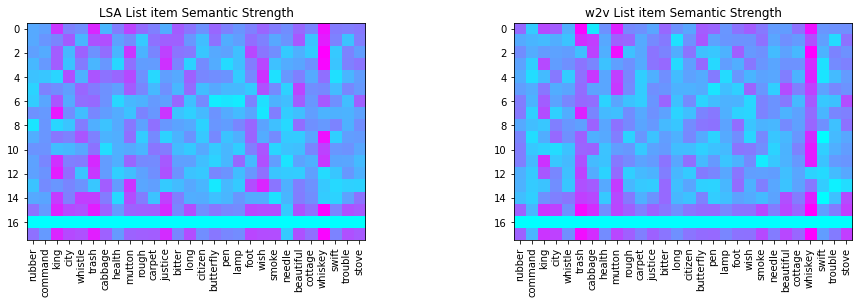

In [29]:
# Compute semantic accumulators for each set of list matrices
accum_lsa_mat = np.zeros((lsa_mat.shape[0],lsa_mat.shape[1]))
accum_w2v_mat = np.zeros((w2v_mat.shape[0],w2v_mat.shape[1]))

for i, crit in enumerate(list_order):
    lsa_sum = np.sum(list_lsa_mat[crit],axis=1) - 1
    w2v_sum = np.sum(list_w2v_mat[crit],axis=1) - 1
    accum_lsa_mat[:list_lsa_mat[crit].shape[0]-1,i] = lsa_sum[1:]
    accum_w2v_mat[:list_w2v_mat[crit].shape[0]-1,i] = w2v_sum[1:]
    accum_lsa_mat[-1,i] = accum_lsa_mat[-3,i] = lsa_sum[0]
    accum_w2v_mat[-1,i] = accum_w2v_mat[-3,i] = w2v_sum[0]

# Matrix heatmap for sum of internal semantic strength of list items
f,axes = plt.subplots(1,2,figsize=(16,4))
plt.sca(axes[0])
axes[0].title.set_text("LSA List item Semantic Strength")
plt.xticks(ticks=range(len(list_order)),labels=list_order,rotation=90)
plt.imshow(accum_lsa_mat,cmap='cool',interpolation='nearest')
plt.sca(axes[1])
axes[1].title.set_text("w2v List item Semantic Strength")
plt.xticks(ticks=range(len(list_order)),labels=list_order,rotation=90)
plt.imshow(accum_w2v_mat,cmap='cool',interpolation='nearest')
plt.show()

It is not obvious at this point that semantics is a good predictor for recall behavior, as we have simply summed cosine values across each row in the within-list matrices to produce each column in this new matrix, some cells have values > 1. Next we normalize each column within [0,1]

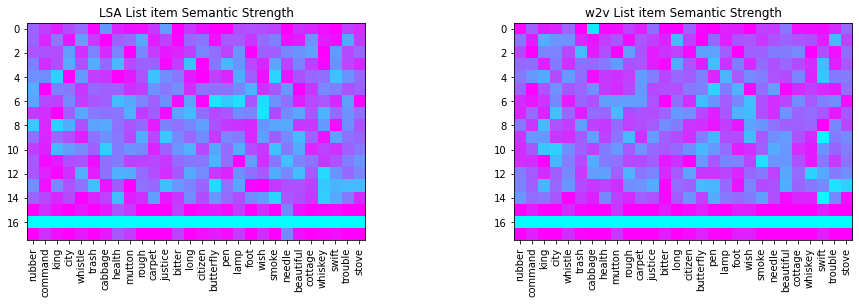

In [30]:
# Store original
orig_accum_lsa_mat = accum_lsa_mat.copy()
orig_accum_w2v_mat = accum_w2v_mat.copy()

# Normalize each column in matrix to [0-1]
accum_lsa_mat = accum_lsa_mat / accum_lsa_mat.max(axis=0)
accum_w2v_mat = accum_w2v_mat / accum_w2v_mat.max(axis=0)

# Matrix heatmap for sum of internal semantic strength of list items
f,axes = plt.subplots(1,2,figsize=(16,4))
plt.sca(axes[0])
axes[0].title.set_text("LSA List item Semantic Strength")
plt.xticks(ticks=range(len(list_order)),labels=list_order,rotation=90)
plt.imshow(accum_lsa_mat,cmap='cool',interpolation='nearest')
plt.sca(axes[1])
axes[1].title.set_text("w2v List item Semantic Strength")
plt.xticks(ticks=range(len(list_order)),labels=list_order,rotation=90)
plt.imshow(accum_w2v_mat,cmap='cool',interpolation='nearest')
plt.show()

**NOTE:** To better model the behavioral/simulation results, there is probably some value above which we simply recall the item (instead of treating each cell value as a literal % recall)

To better illustrate the similarity between the above semantic-only predictor for recall, we run the squared-error plot as before

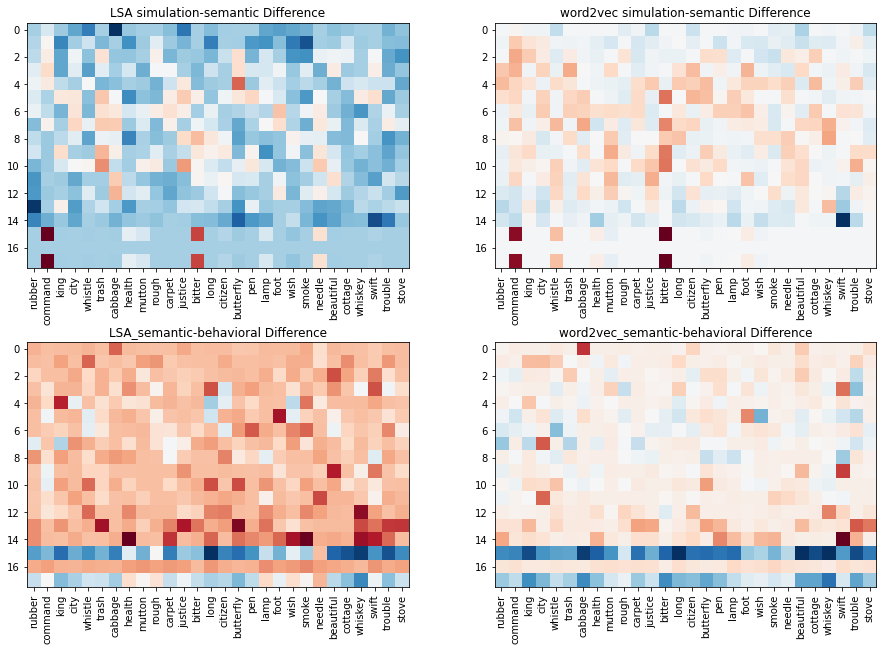

In [31]:
f,axes = plt.subplots(2,2,figsize=(16,8))
f.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.3, wspace=0.1)
# simulation-semantic (LSA) squared difference (preserving sign)
plt.sca(axes[0][0])
axes[0][0].title.set_text("LSA simulation-semantic Difference")
plt.xticks(ticks=range(len(cmr_list_order)),labels=list_order,rotation=90)
diff_mat = lsa_mat-accum_lsa_mat
plt.imshow(np.multiply(np.sign(diff_mat),np.square(diff_mat)),cmap='RdBu',interpolation='nearest')
# simulation-semantic (word2vec) squared difference (preserving sign)
plt.sca(axes[0][1])
axes[0][1].title.set_text("word2vec simulation-semantic Difference")
plt.xticks(ticks=range(len(cmr_w2v_list_order)),labels=list_order,rotation=90)
diff_mat = w2v_mat-accum_w2v_mat
plt.imshow(np.multiply(np.sign(diff_mat),np.square(diff_mat)),cmap='RdBu',interpolation='nearest')
# semantic(LSA)-behavioral squared difference (preserving sign)
plt.sca(axes[1][0])
axes[1][0].title.set_text("LSA_semantic-behavioral Difference")
plt.xticks(ticks=range(len(cmr_list_order)),labels=list_order,rotation=90)
diff_mat = accum_lsa_mat-behavioral_mat
plt.imshow(np.multiply(np.sign(diff_mat),np.square(diff_mat)),cmap='RdBu',interpolation='nearest')
# semantic(word2vec)-behavioral squared difference (preserving sign)
plt.sca(axes[1][1])
axes[1][1].title.set_text("word2vec_semantic-behavioral Difference")
plt.xticks(ticks=range(len(cmr_w2v_list_order)),labels=list_order,rotation=90)
diff_mat = accum_w2v_mat-behavioral_mat
plt.imshow(np.multiply(np.sign(diff_mat),np.square(diff_mat)),cmap='RdBu',interpolation='nearest')
plt.show()

### Semantics overwhelming

Remarkably (or maybe not), we see that the word2vec semantic matrix lies closer to behavioral results - at least for recall of items within the list but highly over-recalls the critical lure. Below is the word2vec_semantic-behavioral and word2vec_simulation-behavioral plots side-by-side to show the difference. Furthermore, we also plot the word2vec_semantic matrix beside the behavioral data matrix for comparison.

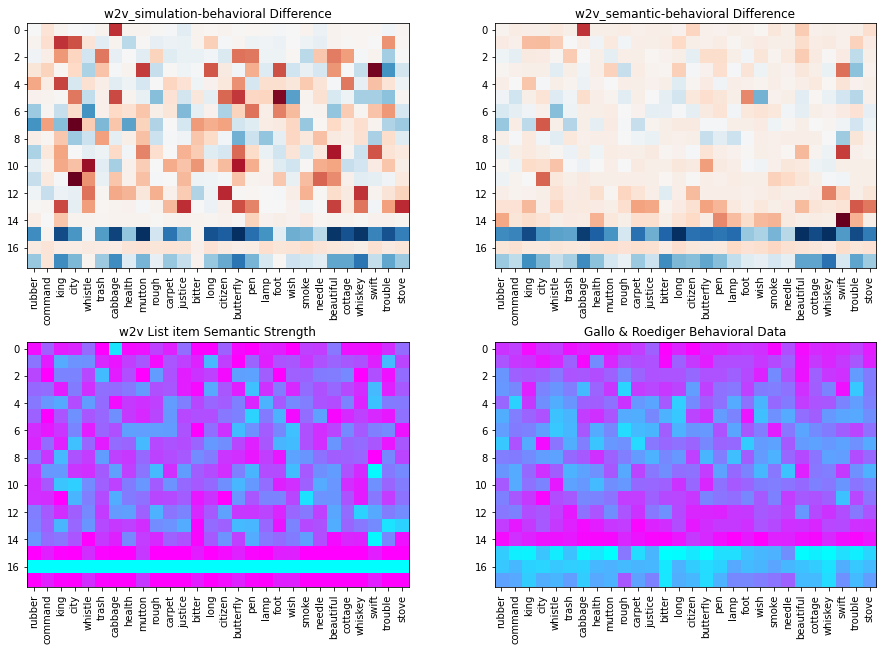

In [32]:
f,axes = plt.subplots(2,2,figsize=(16,8))
f.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.3, wspace=0.1)
# word2vec-behavioral squared difference
plt.sca(axes[0][0])
axes[0][0].title.set_text("w2v_simulation-behavioral Difference")
plt.xticks(ticks=range(len(cmr_w2v_list_order)),labels=list_order,rotation=90)
diff_mat = w2v_mat-behavioral_mat
plt.imshow(np.multiply(np.sign(diff_mat),np.square(diff_mat)),cmap='RdBu',interpolation='nearest')
# semantic(word2vec)-behavioral squared difference (preserving sign)
plt.sca(axes[0][1])
axes[0][1].title.set_text("w2v_semantic-behavioral Difference")
plt.xticks(ticks=range(len(cmr_w2v_list_order)),labels=list_order,rotation=90)
diff_mat = accum_w2v_mat-behavioral_mat
plt.imshow(np.multiply(np.sign(diff_mat),np.square(diff_mat)),cmap='RdBu',interpolation='nearest')
# Word2vec semantic matrix
plt.sca(axes[1][0])
axes[1][0].title.set_text("w2v List item Semantic Strength")
plt.xticks(ticks=range(len(list_order)),labels=list_order,rotation=90)
plt.imshow(accum_w2v_mat,cmap='cool',interpolation='nearest')
# Behavioral data matrix
plt.sca(axes[1][1])
axes[1][1].title.set_text("Gallo & Roediger Behavioral Data")
plt.xticks(ticks=range(len(list_order)),labels=list_order,rotation=90)
plt.imshow(behavioral_mat,cmap='cool',interpolation='nearest')
plt.show()

Although the top-right plot appears to show that semantics within the word2vec space is a good model for recall within list items, it does not perform as well near the edges (start & end of list) which is a region where CMR simulation does well in.